In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
from probabilistic_vq.vector_quantizer import VectorQuantizer
from probabilistic_vq import pass_through
from probabilistic_vq import kl_divergence
from probabilistic_vq import sample_sharply
from probabilistic_vq import sample_softly
from probabilistic_vq import sample_randomly
from probabilistic_vq import sample_best

In [3]:
class Model(tf.keras.models.Model):
    
    def __init__(self, 
                 output_size, 
                 num_codes=10, 
                 num_layers=3, 
                 num_channels=128, 
                 kernel_size=5, 
                 sampling_method=sample_best,
                 pass_through=True,
                 **kwargs):
        """Build a model using a probabilistic vector quantized hidden layer
        
        Arguments:
        num_codes: int, the number of discrete latent variables
        num_layers: the number of downsampling and upsampling layer pairs
        num_channels: the number of channels in the vector quantization layer
        kernel_size: the filter size of the Conv2D weight tensors
        sampling_method: the sampling technique for training the evaluating
            the discrete latent variable
        pass_through: boolean whether to pass gradients directly through 
            sampling into the key tensor
        """
        tf.keras.models.Model.__init__(self, **kwargs)
        self.num_layers = num_layers
        self.pass_through = pass_through
        
        self.conv_layers = []
        self.conv_transpose_layers = []
        self.vq = VectorQuantizer(num_codes, 
                                  num_channels, 
                                  sampling_method=sampling_method)
        
        a_channels = num_channels // 2 ** (self.num_layers - 1)
        b_channels = num_channels // 2
        kwargs = dict(strides=(2, 2), padding='same', data_format='channels_last')
        for i in range(self.num_layers):
            k = kernel_size if i % 2  == 0 else (kernel_size - 1)
            
            self.conv_layers.append(
                tf.keras.layers.Conv2D(a_channels * (2 ** i), k, **kwargs))
            self.conv_transpose_layers.append(
                tf.keras.layers.Conv2DTranspose(
                    b_channels // (2 ** i) if i < 2 else output_size, k, **kwargs))
        
    def call(self, images, **kwargs):
        """Forward pass using probabilistic vector quantization on a 
        discrete latent variable model
        
        Arguments:
        images: float32 tensor with shape [batch_dim, height, width, color_dim]
        
        Returns:
        float32 tensor with shape [batch_dim, height, width, color_dim]
        float32 tensor with shape [,]
        """
        x = images
        for i in range(self.num_layers):
            x = self.conv_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)
            
        logits = self.vq(x, **kwargs)
        z = self.vq.sample(logits, **kwargs)
        x = pass_through(x, z) if self.pass_through else z
        
        for i in range(self.num_layers):
            x = self.conv_transpose_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)

        log_p = tf.math.log_softmax(logits)
        uniform_log_p = -tf.math.log(
            tf.fill(tf.shape(logits), tf.cast(tf.shape(logits)[-1], tf.float32)))
        
        return (tf.nn.tanh(x), 
                tf.reduce_mean(kl_divergence(log_p, uniform_log_p)))

In [4]:
model = Model(
    3, 
    num_codes=512, 
    num_layers=3, 
    num_channels=128, 
    kernel_size=5)

In [5]:
dataset = tfds.load(name="cifar10", split="train")
dataset = dataset.repeat(100).shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
optim = tf.keras.optimizers.Adam()

In [7]:
def loss_function(images):
    x, kl_loss = model(images)
    return 0.0 * kl_loss + tf.reduce_mean(
        tf.keras.losses.mean_squared_error(images, x))

[Iteration 0] -- MSE: 0.30684518814086914, KL: 5.90507698059082


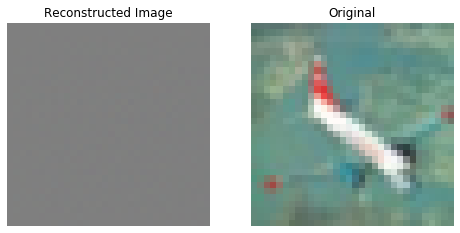

[Iteration 100] -- MSE: 0.16323505342006683, KL: 6.189896106719971


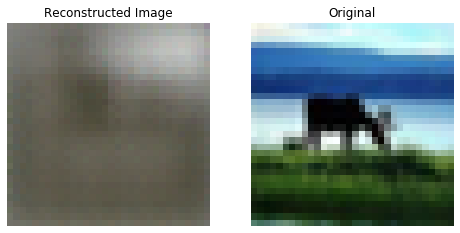

[Iteration 200] -- MSE: 0.17005190253257751, KL: 6.222733020782471


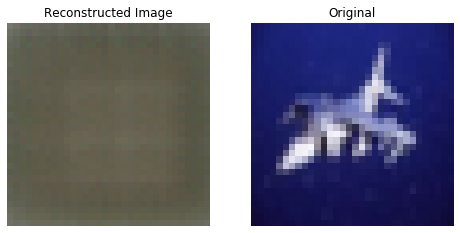

[Iteration 300] -- MSE: 0.15748831629753113, KL: 5.681140422821045


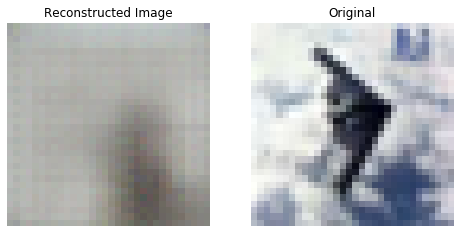

[Iteration 400] -- MSE: 0.14915981888771057, KL: 4.774477958679199


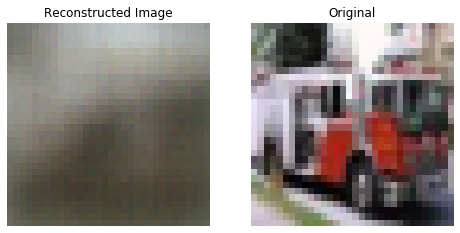

[Iteration 500] -- MSE: 0.147312194108963, KL: 4.17210578918457


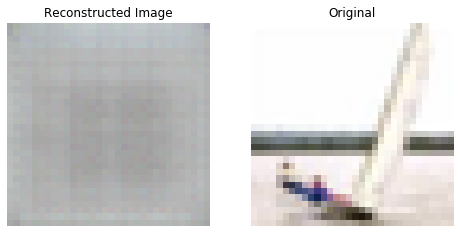

[Iteration 600] -- MSE: 0.15914908051490784, KL: 3.316338539123535


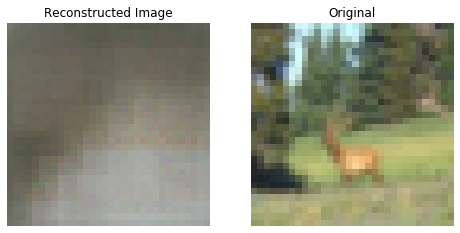

[Iteration 700] -- MSE: 0.19377847015857697, KL: 2.664547920227051


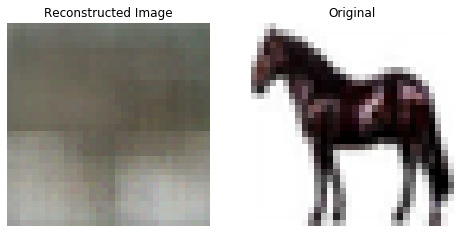

[Iteration 800] -- MSE: 0.20940017700195312, KL: 1.6069711446762085


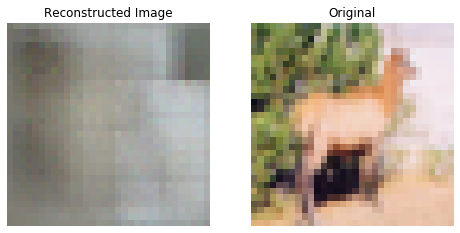

[Iteration 900] -- MSE: 0.19688361883163452, KL: 1.263273000717163


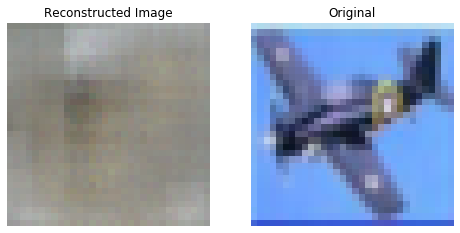

[Iteration 1000] -- MSE: 0.23901359736919403, KL: 0.6637500524520874


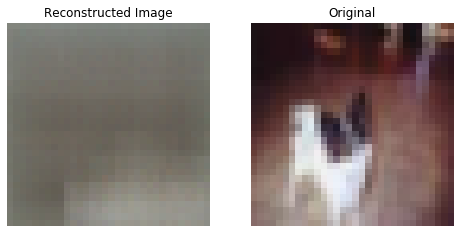

[Iteration 1100] -- MSE: 0.2230384647846222, KL: 0.5660495758056641


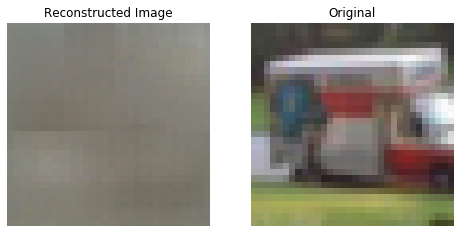

[Iteration 1200] -- MSE: 0.27373194694519043, KL: 0.2908850610256195


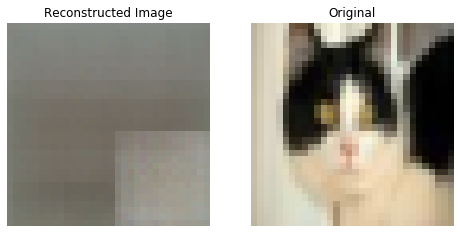

[Iteration 1300] -- MSE: 0.2375408411026001, KL: 0.40282511711120605


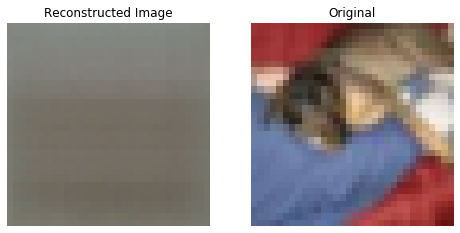

[Iteration 1400] -- MSE: 0.22835202515125275, KL: 0.22574375569820404


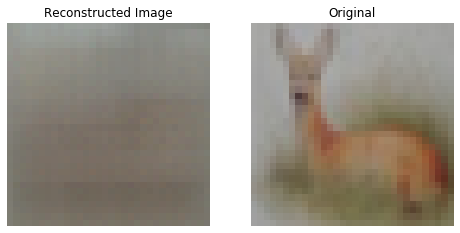

[Iteration 1500] -- MSE: 0.28129303455352783, KL: 0.22236895561218262


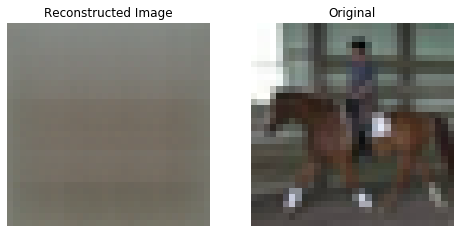

[Iteration 1600] -- MSE: 0.28113508224487305, KL: 0.2022765874862671


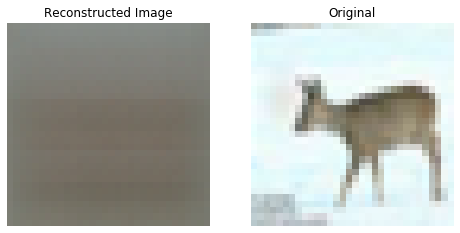

[Iteration 1700] -- MSE: 0.2520114779472351, KL: 0.11404712498188019


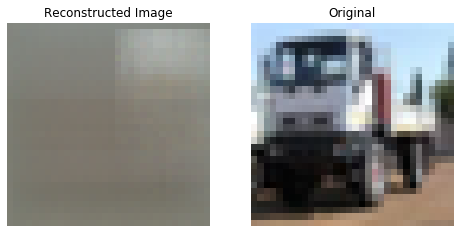

[Iteration 1800] -- MSE: 0.24683983623981476, KL: 0.1756303757429123


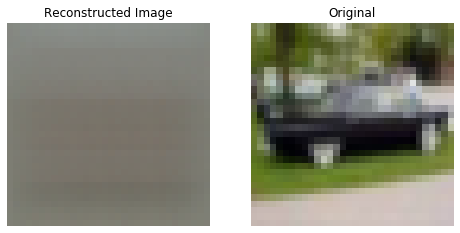

[Iteration 1900] -- MSE: 0.24709951877593994, KL: 0.05317448079586029


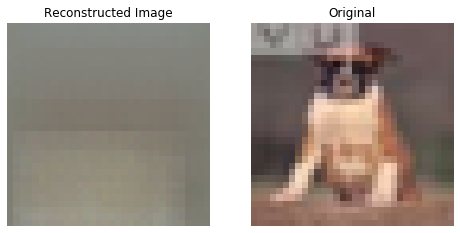

[Iteration 2000] -- MSE: 0.2542782425880432, KL: 0.12094412744045258


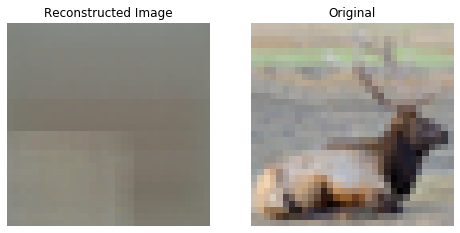

[Iteration 2100] -- MSE: 0.25950926542282104, KL: 0.06038829684257507


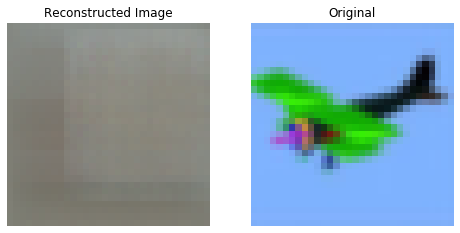

[Iteration 2200] -- MSE: 0.3125290870666504, KL: 0.03341703116893768


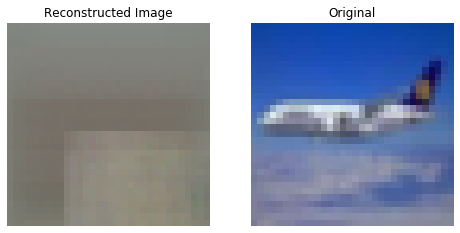

[Iteration 2300] -- MSE: 0.23858851194381714, KL: 0.020296934992074966


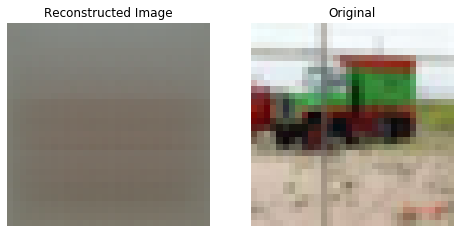

[Iteration 2400] -- MSE: 0.2624070644378662, KL: 0.08923417329788208


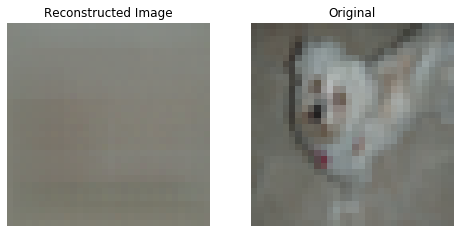

[Iteration 2500] -- MSE: 0.24337707459926605, KL: 0.011120793409645557


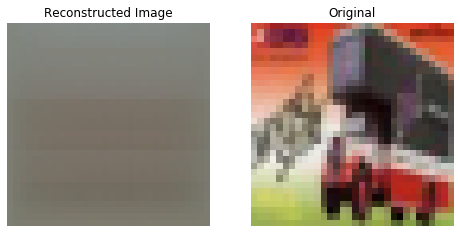

[Iteration 2600] -- MSE: 0.24509947001934052, KL: 0.021734569221735


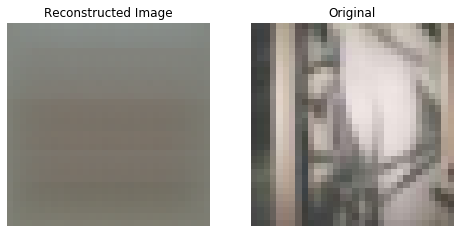

[Iteration 2700] -- MSE: 0.2059890329837799, KL: 0.08956962823867798


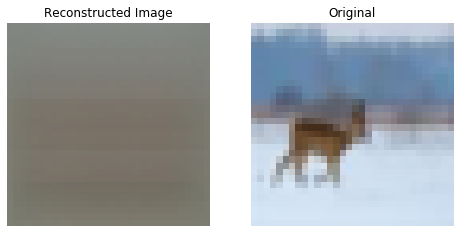

[Iteration 2800] -- MSE: 0.27103421092033386, KL: 0.032827891409397125


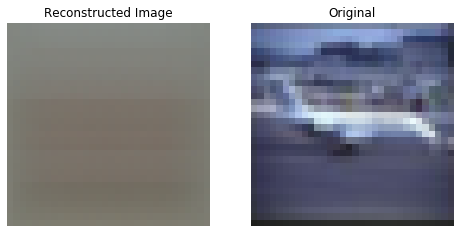

[Iteration 2900] -- MSE: 0.2400987595319748, KL: 0.037653304636478424


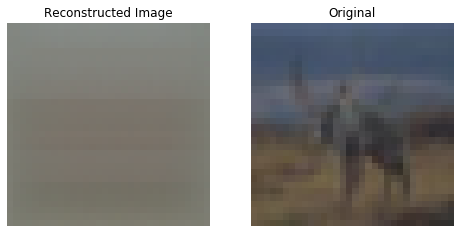

[Iteration 3000] -- MSE: 0.25980159640312195, KL: 3.818426193902269e-06


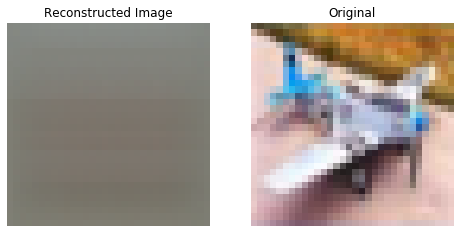

[Iteration 3100] -- MSE: 0.23866266012191772, KL: 0.01218422781676054


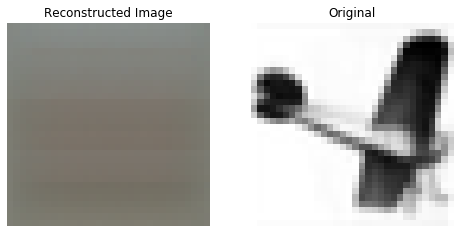

[Iteration 3200] -- MSE: 0.23860299587249756, KL: 0.005696611013263464


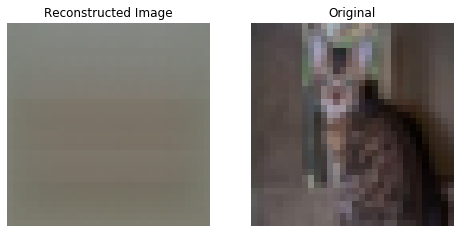

[Iteration 3300] -- MSE: 0.22932693362236023, KL: 0.03133724257349968


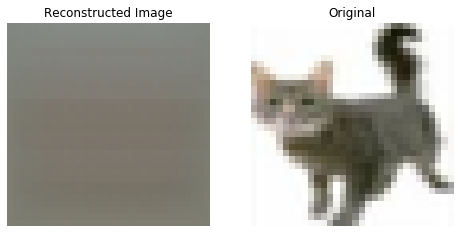

[Iteration 3400] -- MSE: 0.23805592954158783, KL: 0.016433581709861755


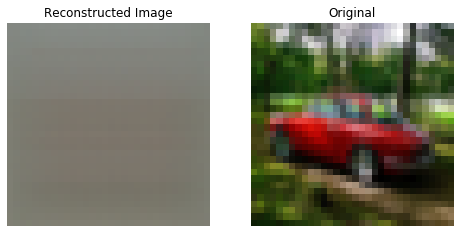

[Iteration 3500] -- MSE: 0.30763351917266846, KL: 0.006241712719202042


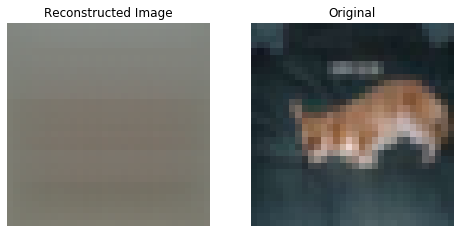

[Iteration 3600] -- MSE: 0.20311857759952545, KL: 0.008635194972157478


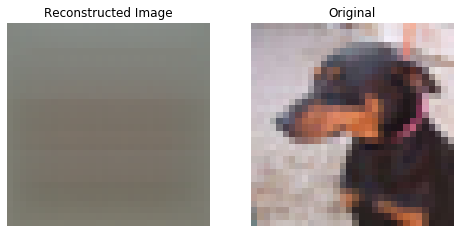

[Iteration 3700] -- MSE: 0.24736523628234863, KL: 0.006748382933437824


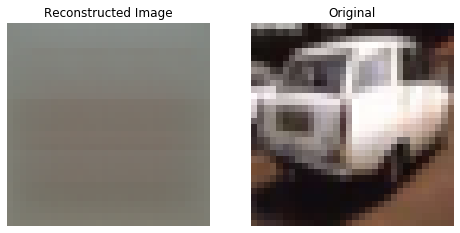

[Iteration 3800] -- MSE: 0.2401629090309143, KL: 0.0


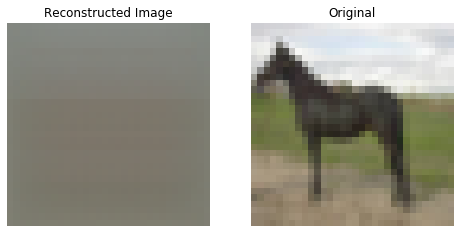

[Iteration 3900] -- MSE: 0.27134543657302856, KL: 3.818426193902269e-06


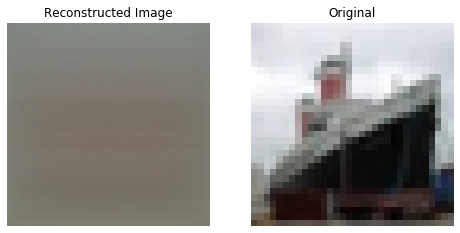

[Iteration 4000] -- MSE: 0.2602647840976715, KL: 0.010830424726009369


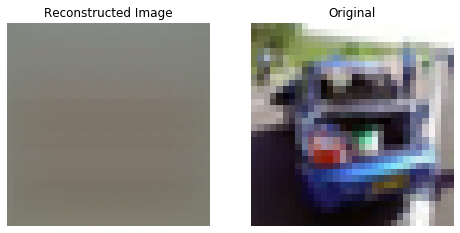

[Iteration 4100] -- MSE: 0.23248380422592163, KL: 0.025385409593582153


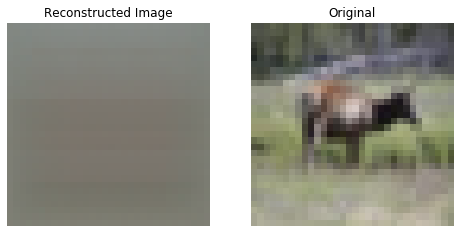

[Iteration 4200] -- MSE: 0.24032966792583466, KL: 0.0


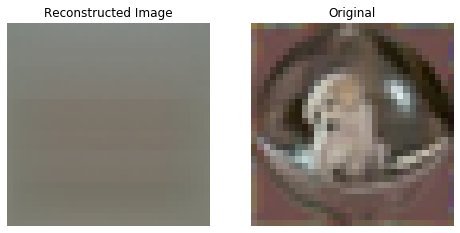

[Iteration 4300] -- MSE: 0.2807008624076843, KL: 0.0020094504579901695


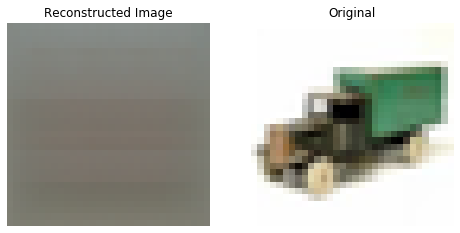

[Iteration 4400] -- MSE: 0.23831674456596375, KL: 0.002251334022730589


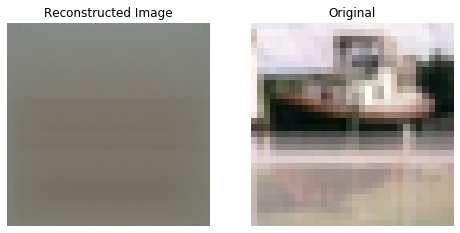

[Iteration 4500] -- MSE: 0.22774723172187805, KL: 0.0030419842805713415


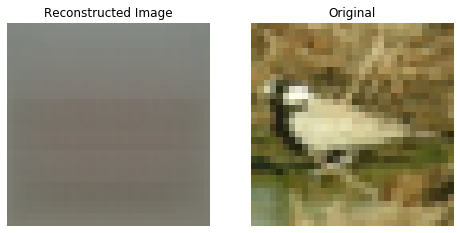

[Iteration 4600] -- MSE: 0.24329710006713867, KL: 0.014408523216843605


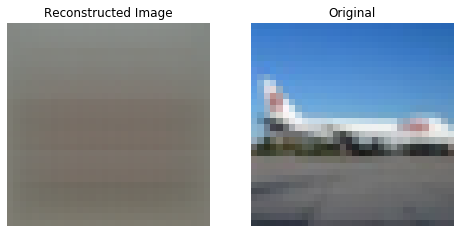

[Iteration 4700] -- MSE: 0.2850300669670105, KL: 0.0


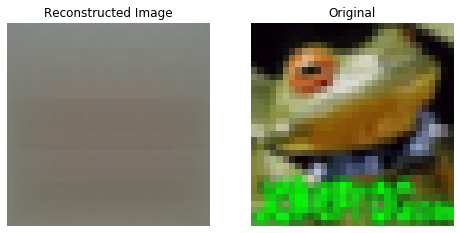

[Iteration 4800] -- MSE: 0.25310438871383667, KL: 0.007174561731517315


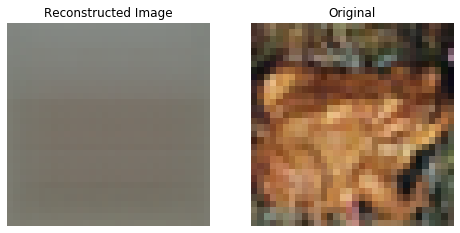

[Iteration 4900] -- MSE: 0.2630574107170105, KL: 0.0


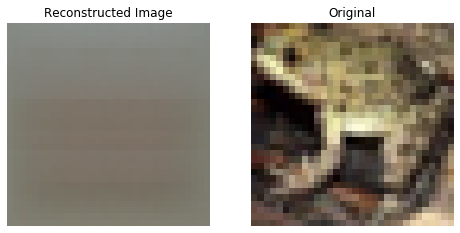

[Iteration 5000] -- MSE: 0.29553255438804626, KL: 0.0


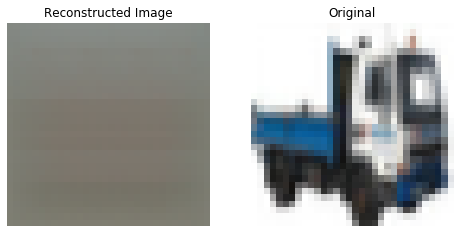

[Iteration 5100] -- MSE: 0.22592699527740479, KL: 0.012347248382866383


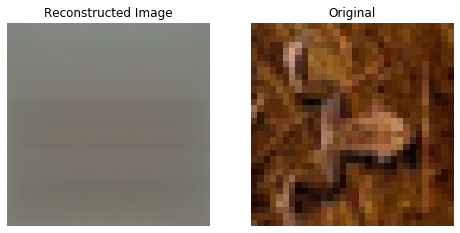

[Iteration 5200] -- MSE: 0.24789124727249146, KL: 0.006957076024264097


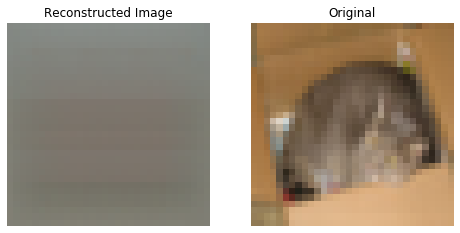

[Iteration 5300] -- MSE: 0.26684969663619995, KL: 0.0


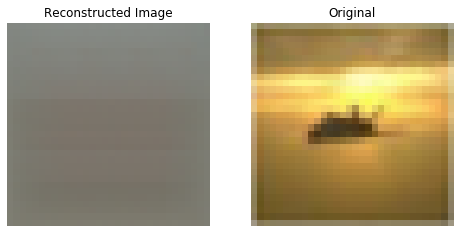

[Iteration 5400] -- MSE: 0.24011445045471191, KL: 0.0


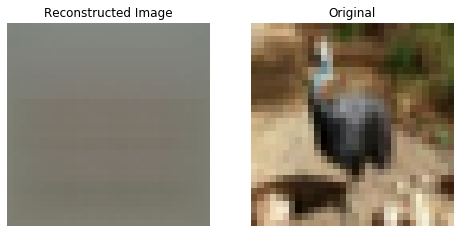

[Iteration 5500] -- MSE: 0.2593158185482025, KL: 0.0


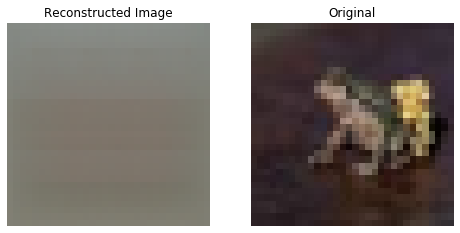

[Iteration 5600] -- MSE: 0.264242947101593, KL: 0.0


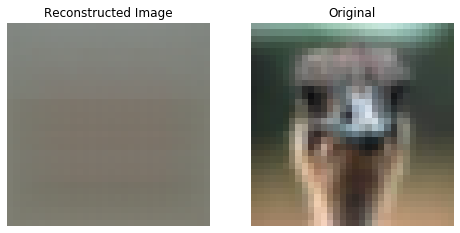

[Iteration 5700] -- MSE: 0.2257835566997528, KL: 0.0


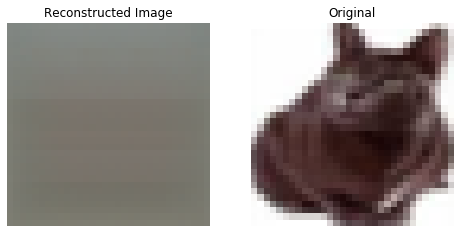

[Iteration 5800] -- MSE: 0.26520872116088867, KL: 0.0


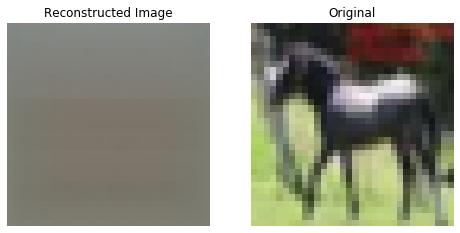

[Iteration 5900] -- MSE: 0.25275808572769165, KL: 0.0


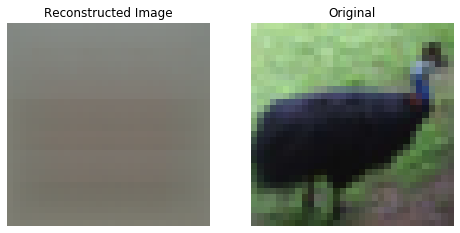

[Iteration 6000] -- MSE: 0.21901553869247437, KL: 0.0


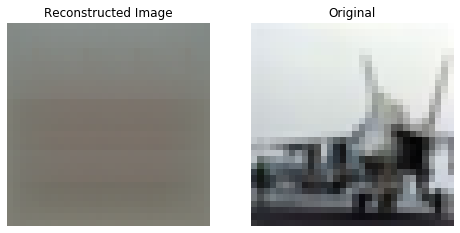

[Iteration 6100] -- MSE: 0.2598809599876404, KL: 0.0


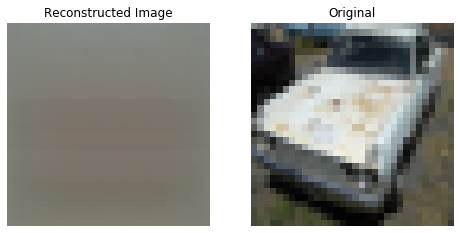

[Iteration 6200] -- MSE: 0.24467751383781433, KL: 0.01218422781676054


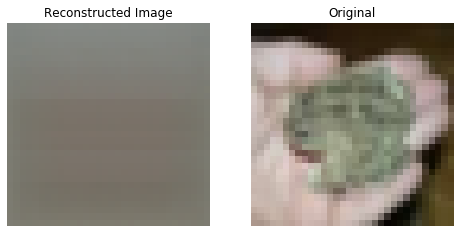

[Iteration 6300] -- MSE: 0.21880647540092468, KL: 0.0036294003948569298


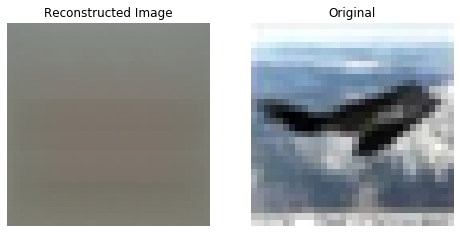

[Iteration 6400] -- MSE: 0.2510792016983032, KL: 0.006538970395922661


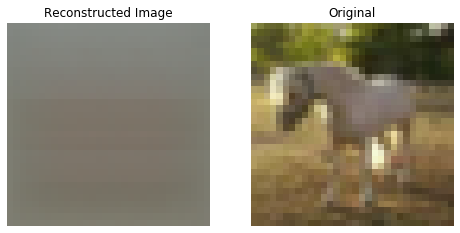

[Iteration 6500] -- MSE: 0.2282746583223343, KL: 0.0004235001979395747


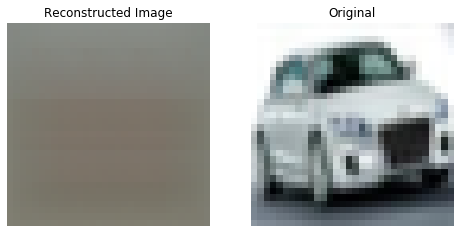

[Iteration 6600] -- MSE: 0.2985684871673584, KL: 0.0


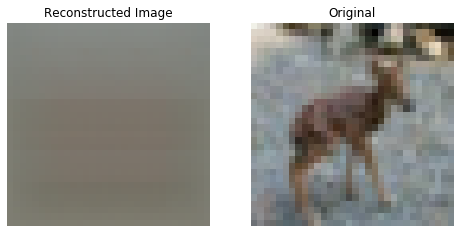

[Iteration 6700] -- MSE: 0.2396213412284851, KL: 0.0


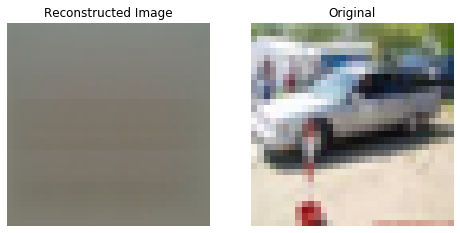

[Iteration 6800] -- MSE: 0.25307703018188477, KL: 0.0


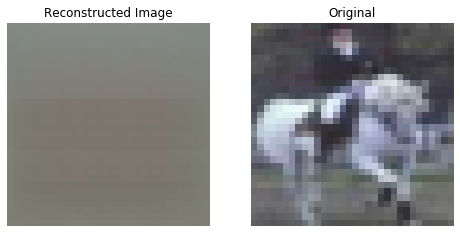

[Iteration 6900] -- MSE: 0.2442867010831833, KL: 0.0


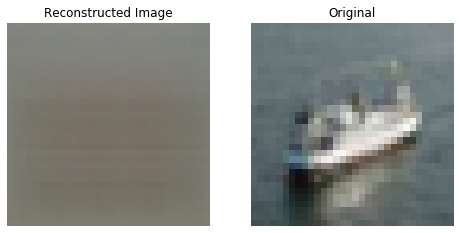

[Iteration 7000] -- MSE: 0.2628924250602722, KL: 0.0


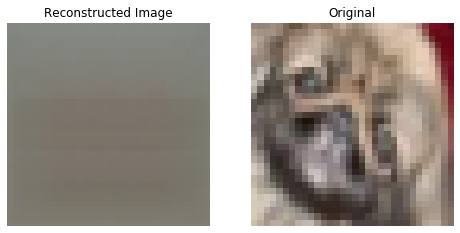

[Iteration 7100] -- MSE: 0.21769572794437408, KL: 4.6321190893650055e-05


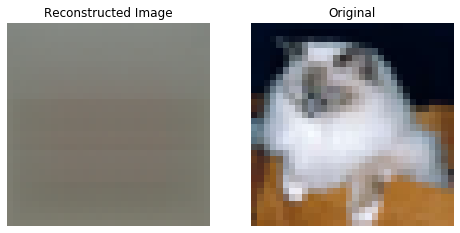

[Iteration 7200] -- MSE: 0.22819527983665466, KL: 0.0


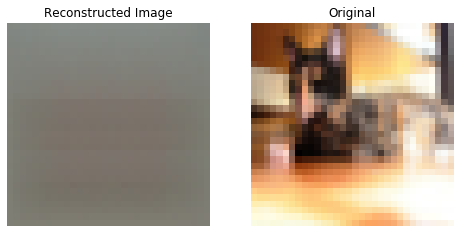

[Iteration 7300] -- MSE: 0.24713316559791565, KL: 0.0


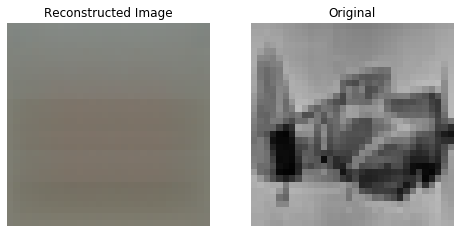

[Iteration 7400] -- MSE: 0.2523324489593506, KL: 0.0


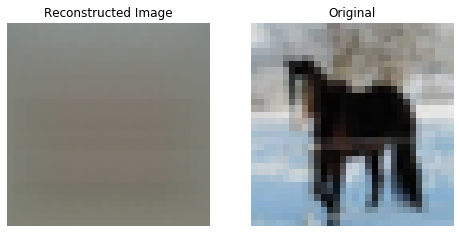

[Iteration 7500] -- MSE: 0.252125084400177, KL: 0.0


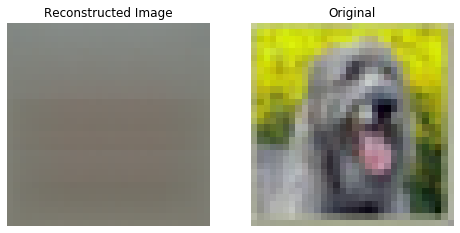

[Iteration 7600] -- MSE: 0.2389613538980484, KL: 0.0


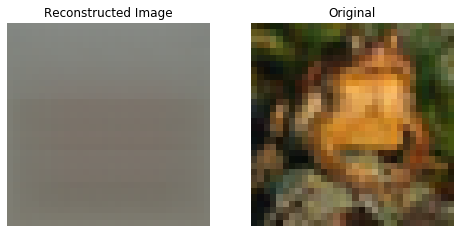

[Iteration 7700] -- MSE: 0.2807702124118805, KL: 7.644294782949146e-06


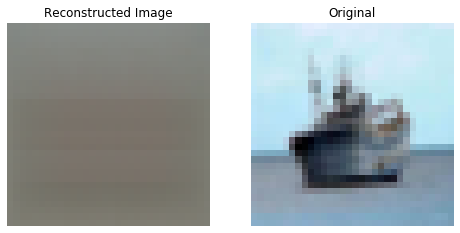

[Iteration 7800] -- MSE: 0.2511153519153595, KL: 0.0


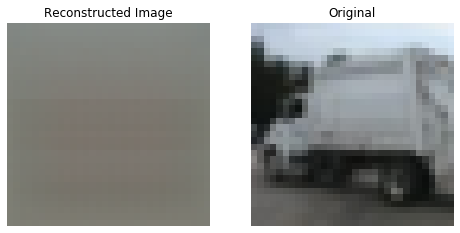

[Iteration 7900] -- MSE: 0.2483324259519577, KL: 0.0


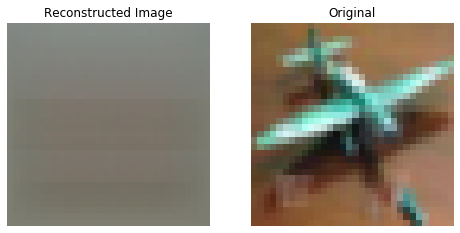

[Iteration 8000] -- MSE: 0.21909627318382263, KL: 0.0


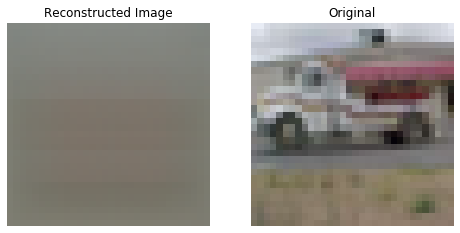

[Iteration 8100] -- MSE: 0.25137394666671753, KL: 0.0


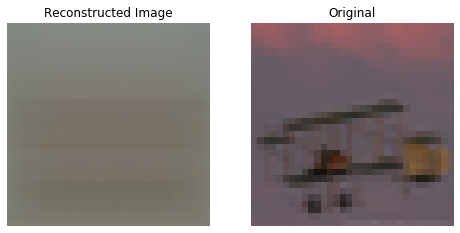

[Iteration 8200] -- MSE: 0.2703213393688202, KL: 0.0


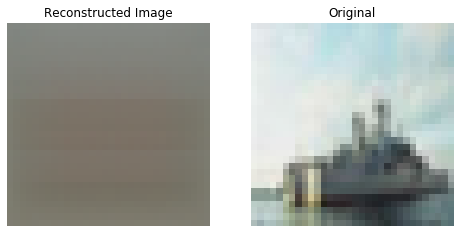

[Iteration 8300] -- MSE: 0.2824553847312927, KL: 0.0


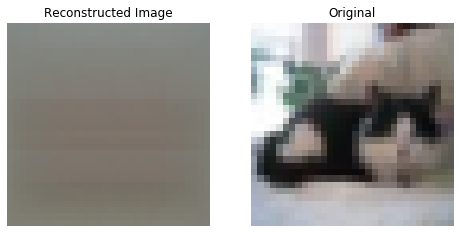

[Iteration 8400] -- MSE: 0.27291813492774963, KL: 0.0


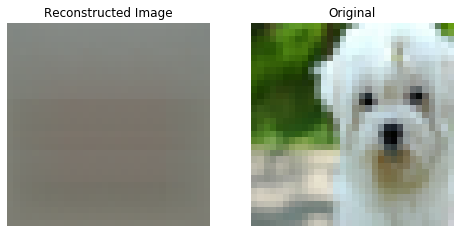

[Iteration 8500] -- MSE: 0.22614048421382904, KL: 2.294033401994966e-05


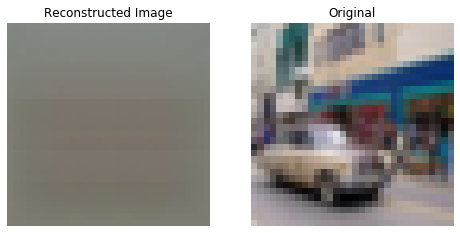

[Iteration 8600] -- MSE: 0.2091546505689621, KL: 5.807538764202036e-05


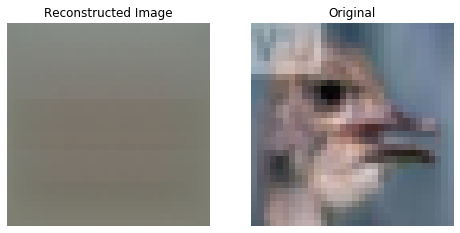

[Iteration 8700] -- MSE: 0.25835132598876953, KL: 0.0


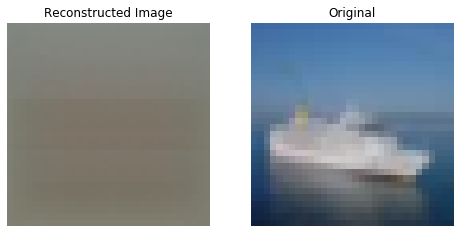

[Iteration 8800] -- MSE: 0.2229211926460266, KL: 0.0


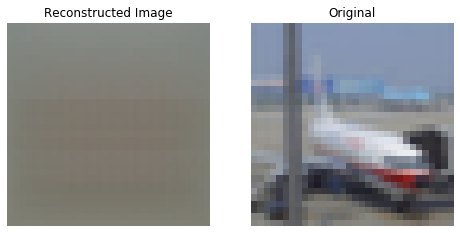

[Iteration 8900] -- MSE: 0.23867815732955933, KL: 0.010830424726009369


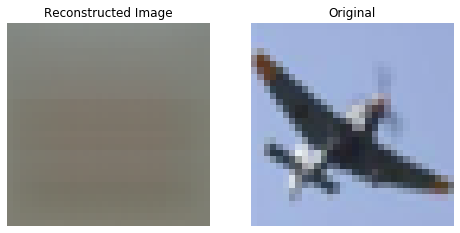

[Iteration 9000] -- MSE: 0.24954980611801147, KL: 0.0


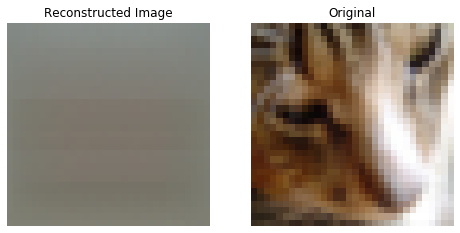

[Iteration 9100] -- MSE: 0.24544835090637207, KL: 3.818426193902269e-06


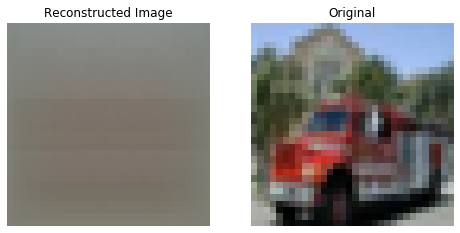

[Iteration 9200] -- MSE: 0.2387697696685791, KL: 0.0


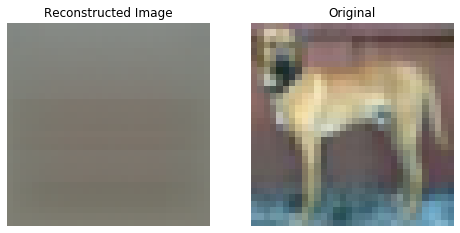

[Iteration 9300] -- MSE: 0.2501929998397827, KL: 0.01218422781676054


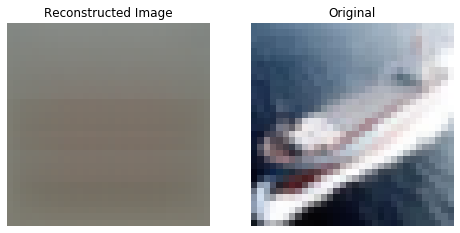

[Iteration 9400] -- MSE: 0.2532932162284851, KL: 3.46377601090353e-05


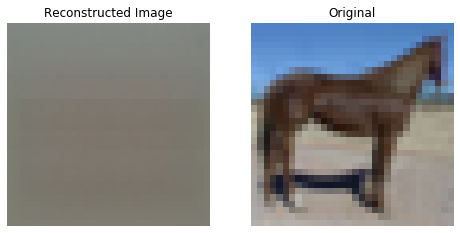

[Iteration 9500] -- MSE: 0.23329487442970276, KL: 0.0


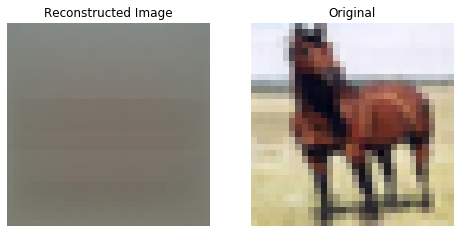

[Iteration 9600] -- MSE: 0.2731137275695801, KL: 0.0


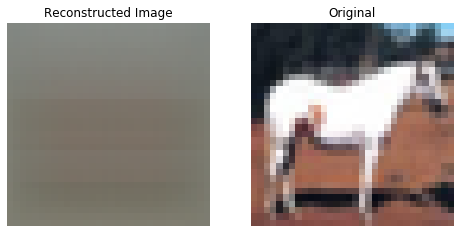

[Iteration 9700] -- MSE: 0.24766235053539276, KL: 0.0


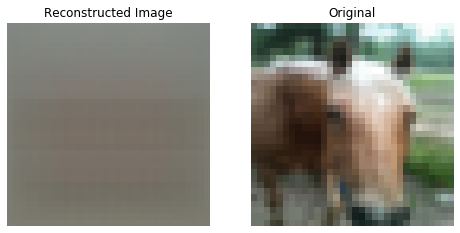

[Iteration 9800] -- MSE: 0.23989179730415344, KL: 0.0


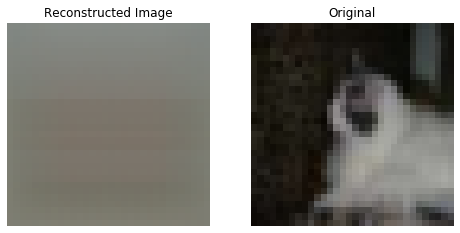

[Iteration 9900] -- MSE: 0.23735551536083221, KL: 0.0


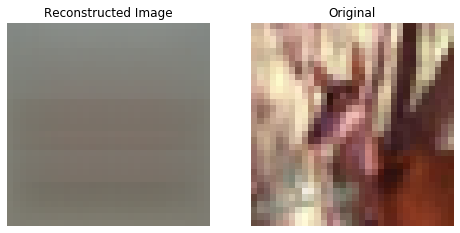

[Iteration 10000] -- MSE: 0.25006842613220215, KL: 0.0


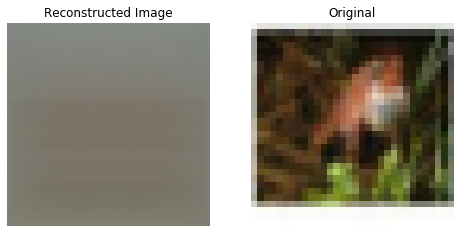

[Iteration 10100] -- MSE: 0.266275554895401, KL: 0.0


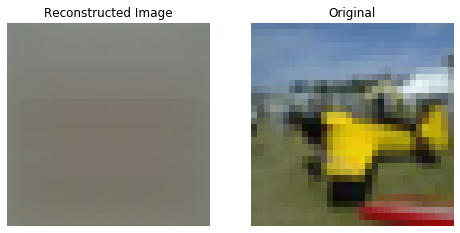

[Iteration 10200] -- MSE: 0.20486274361610413, KL: 0.0


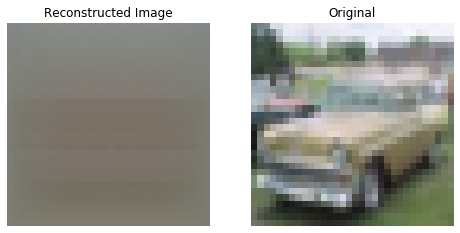

[Iteration 10300] -- MSE: 0.24021519720554352, KL: 0.0


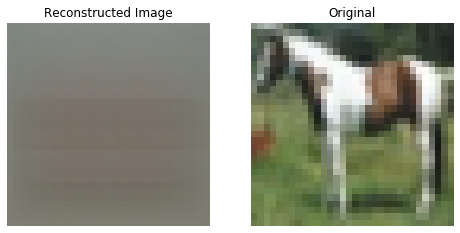

[Iteration 10400] -- MSE: 0.23619064688682556, KL: 0.0


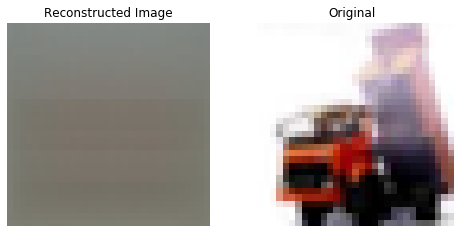

[Iteration 10500] -- MSE: 0.2581818103790283, KL: 0.0


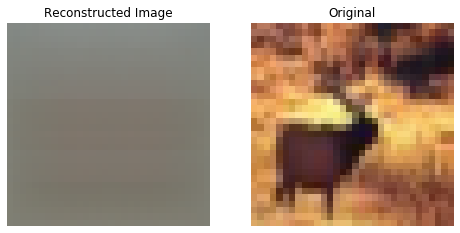

[Iteration 10600] -- MSE: 0.245742529630661, KL: 0.0


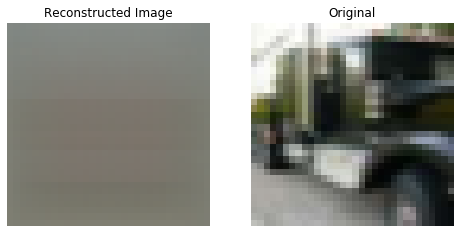

[Iteration 10700] -- MSE: 0.2343180924654007, KL: 0.0


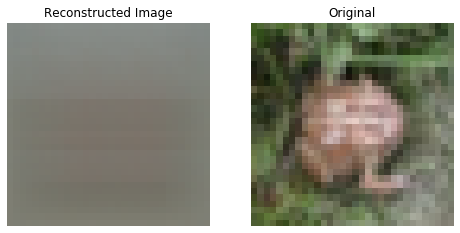

[Iteration 10800] -- MSE: 0.23972088098526, KL: 0.0


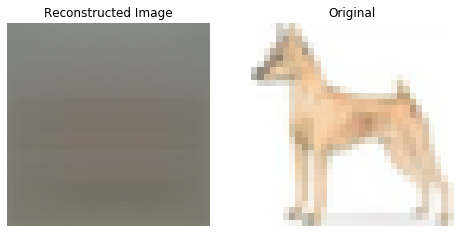

[Iteration 10900] -- MSE: 0.25562891364097595, KL: 0.0


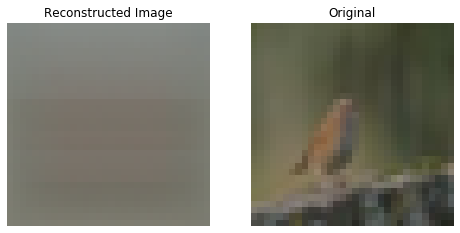

[Iteration 11000] -- MSE: 0.2498946189880371, KL: 0.0


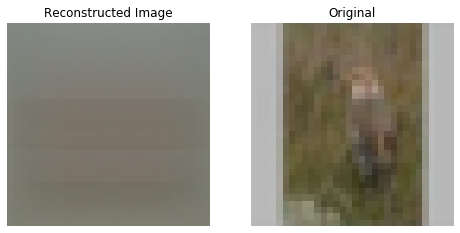

[Iteration 11100] -- MSE: 0.2506479024887085, KL: 0.0


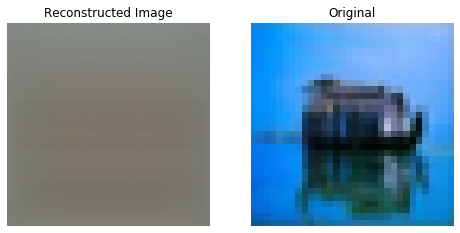

[Iteration 11200] -- MSE: 0.23960846662521362, KL: 0.0


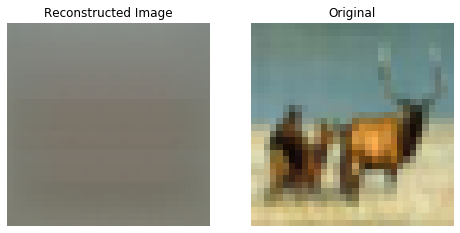

[Iteration 11300] -- MSE: 0.2569548189640045, KL: 0.0


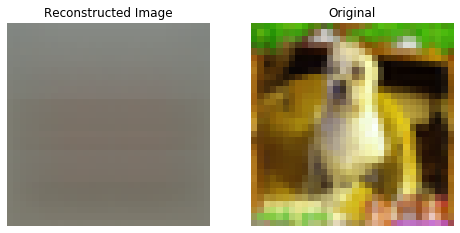

[Iteration 11400] -- MSE: 0.2137274146080017, KL: 0.0


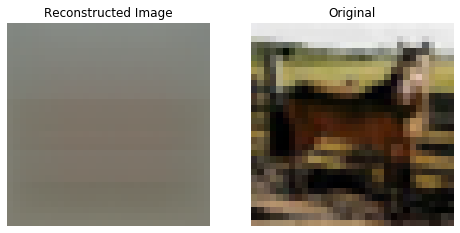

[Iteration 11500] -- MSE: 0.24717190861701965, KL: 0.0


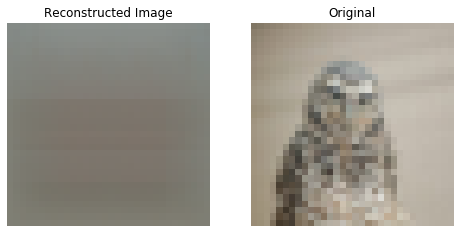

[Iteration 11600] -- MSE: 0.2639492154121399, KL: 0.0


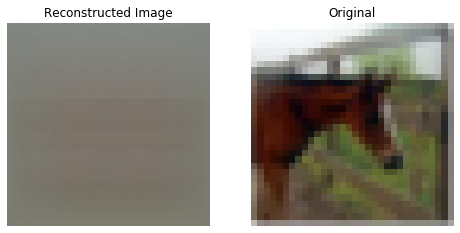

[Iteration 11700] -- MSE: 0.2411174476146698, KL: 0.0


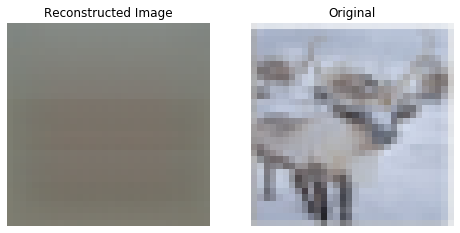

[Iteration 11800] -- MSE: 0.20529384911060333, KL: 0.0


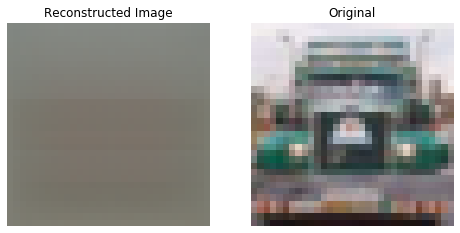

[Iteration 11900] -- MSE: 0.24417726695537567, KL: 0.0


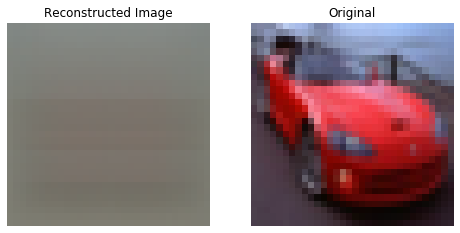

[Iteration 12000] -- MSE: 0.23025161027908325, KL: 0.0


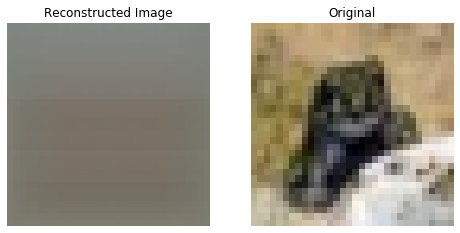

[Iteration 12100] -- MSE: 0.2491471767425537, KL: 0.0


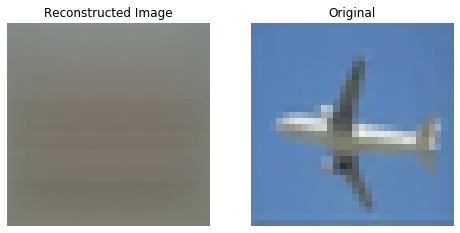

[Iteration 12200] -- MSE: 0.31035226583480835, KL: 0.0


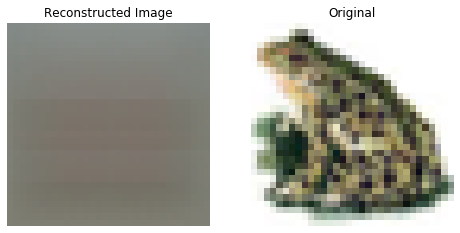

[Iteration 12300] -- MSE: 0.27163293957710266, KL: 0.0


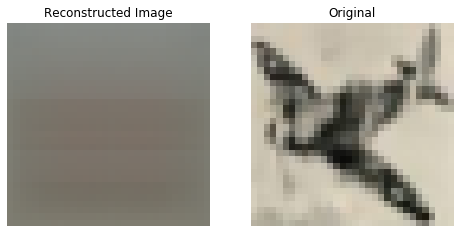

[Iteration 12400] -- MSE: 0.22432571649551392, KL: 0.0


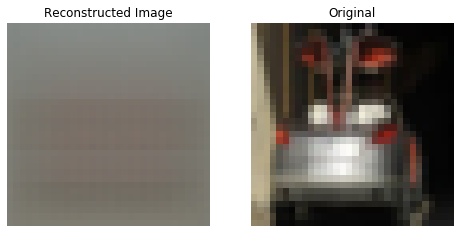

[Iteration 12500] -- MSE: 0.23240453004837036, KL: 0.0


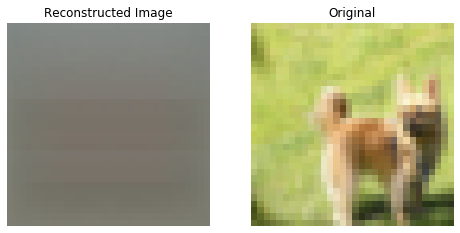

[Iteration 12600] -- MSE: 0.25211504101753235, KL: 0.01218422781676054


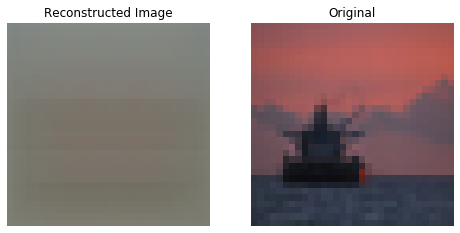

[Iteration 12700] -- MSE: 0.2770548462867737, KL: 0.0


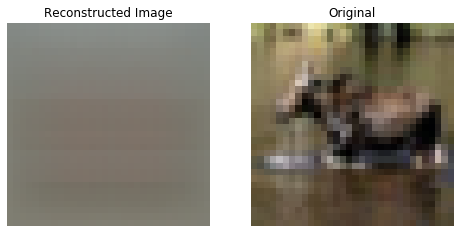

[Iteration 12800] -- MSE: 0.2768401503562927, KL: 0.0


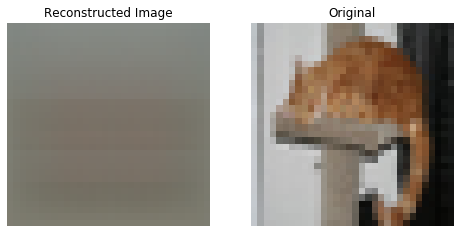

[Iteration 12900] -- MSE: 0.2905074954032898, KL: 0.0


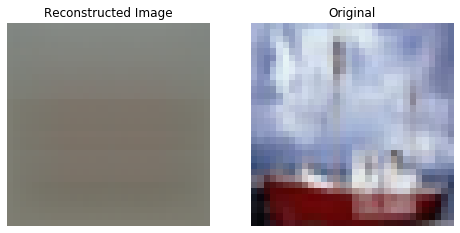

[Iteration 13000] -- MSE: 0.24854356050491333, KL: 0.0


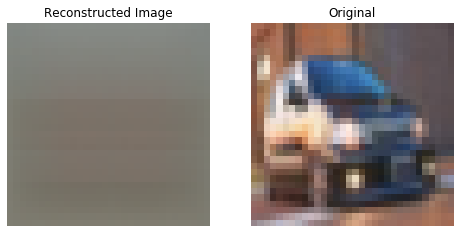

[Iteration 13100] -- MSE: 0.2179194986820221, KL: 0.0


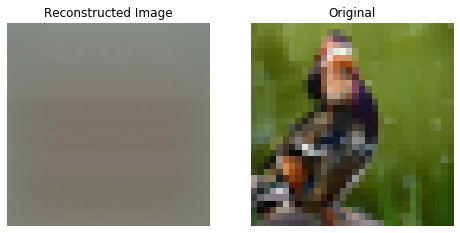

[Iteration 13200] -- MSE: 0.21749141812324524, KL: 0.0


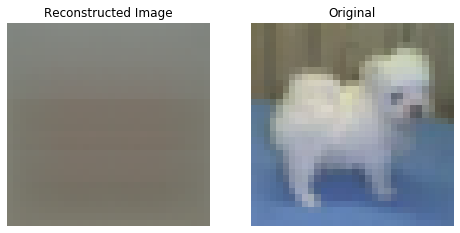

[Iteration 13300] -- MSE: 0.22923414409160614, KL: 0.0


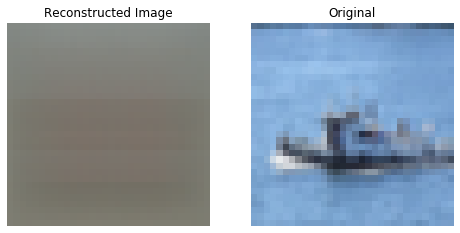

[Iteration 13400] -- MSE: 0.25729718804359436, KL: 0.0


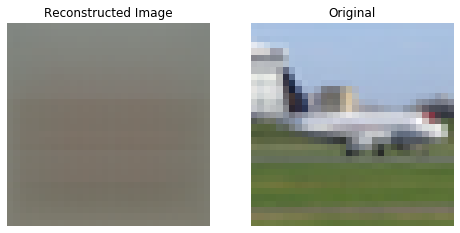

[Iteration 13500] -- MSE: 0.26508456468582153, KL: 0.0


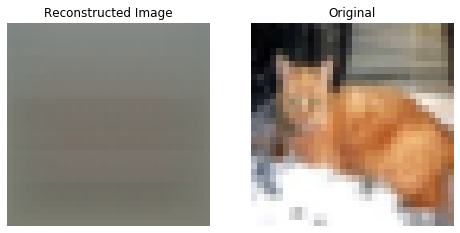

[Iteration 13600] -- MSE: 0.25982600450515747, KL: 0.0


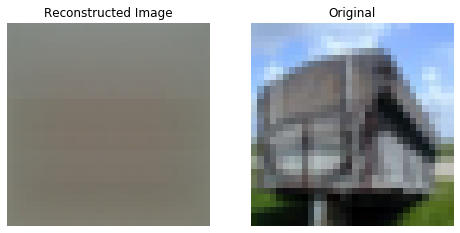

[Iteration 13700] -- MSE: 0.26235315203666687, KL: 0.0


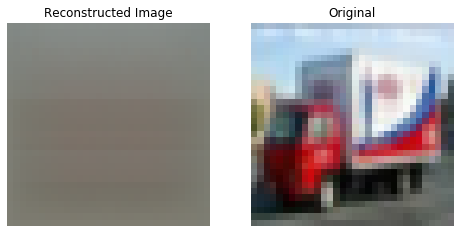

[Iteration 13800] -- MSE: 0.26054373383522034, KL: 0.0


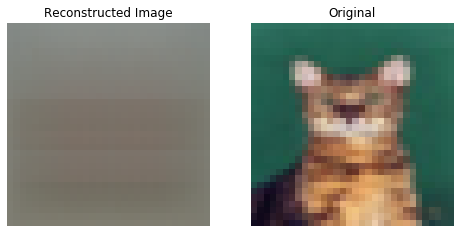

[Iteration 13900] -- MSE: 0.24961356818675995, KL: 0.0


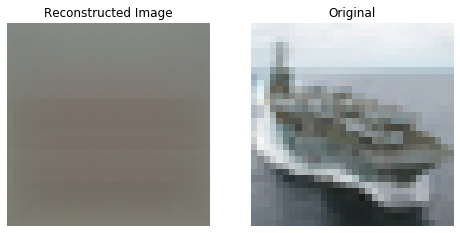

[Iteration 14000] -- MSE: 0.23905061185359955, KL: 0.0


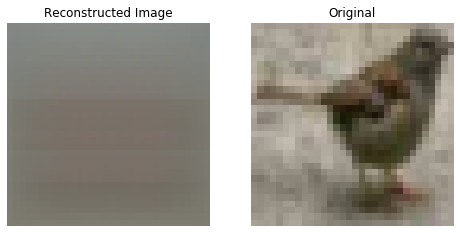

[Iteration 14100] -- MSE: 0.22059528529644012, KL: 0.0


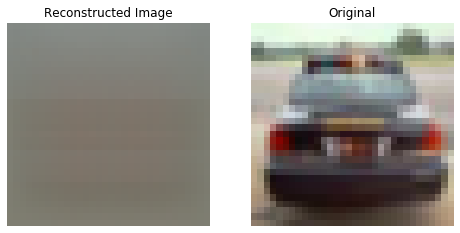

[Iteration 14200] -- MSE: 0.22936546802520752, KL: 0.0


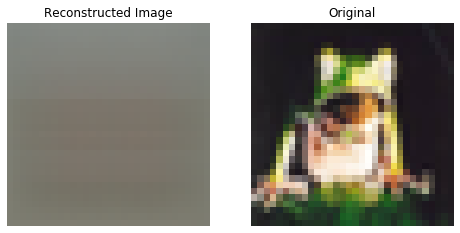

[Iteration 14300] -- MSE: 0.2581547796726227, KL: 0.0


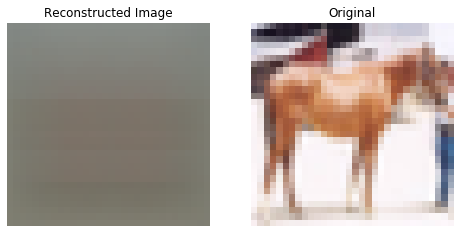

[Iteration 14400] -- MSE: 0.24601462483406067, KL: 0.0


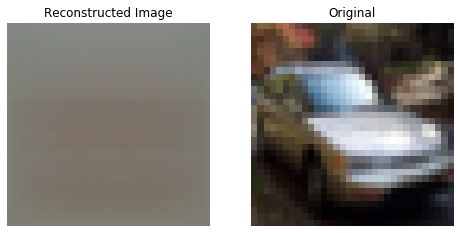

[Iteration 14500] -- MSE: 0.25894176959991455, KL: 0.0


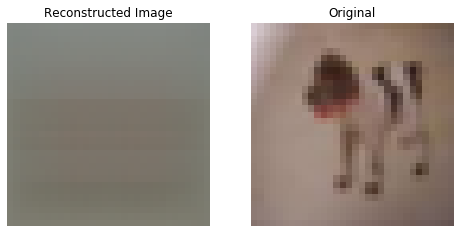

[Iteration 14600] -- MSE: 0.2203345149755478, KL: 0.0


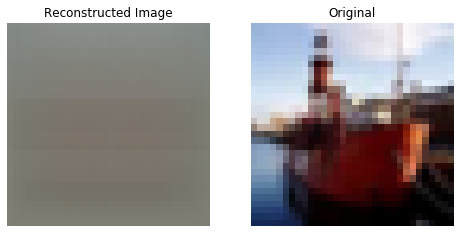

[Iteration 14700] -- MSE: 0.25518155097961426, KL: 0.0


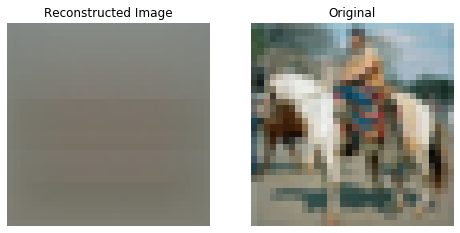

[Iteration 14800] -- MSE: 0.2415461540222168, KL: 0.0


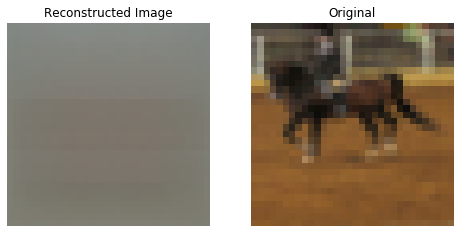

[Iteration 14900] -- MSE: 0.2670363187789917, KL: 0.0


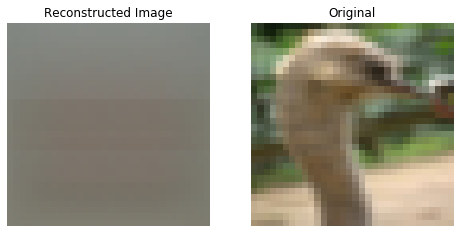

[Iteration 15000] -- MSE: 0.24101446568965912, KL: 0.0


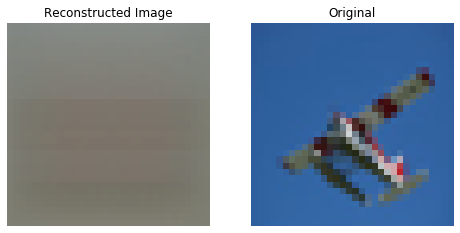

[Iteration 15100] -- MSE: 0.24203552305698395, KL: 0.0


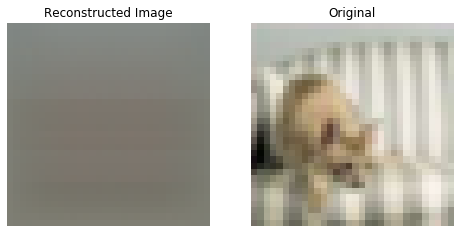

[Iteration 15200] -- MSE: 0.27469825744628906, KL: 0.0


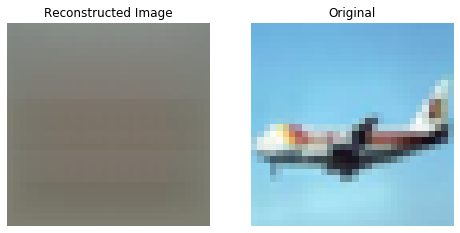

[Iteration 15300] -- MSE: 0.2460232377052307, KL: 0.0


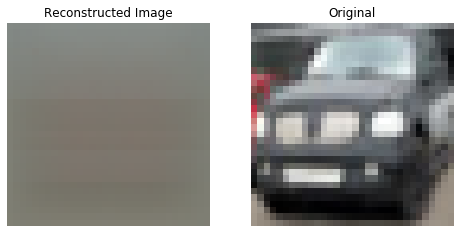

[Iteration 15400] -- MSE: 0.2105228304862976, KL: 0.0


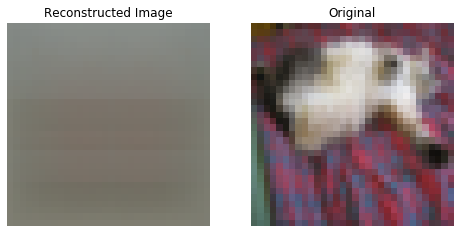

[Iteration 15500] -- MSE: 0.22532594203948975, KL: 0.0


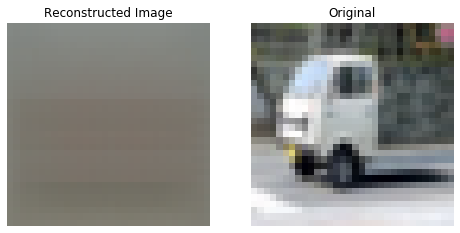

[Iteration 15600] -- MSE: 0.2733040452003479, KL: 0.0


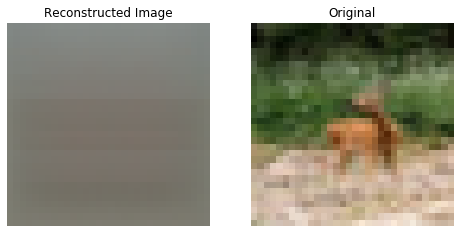

[Iteration 15700] -- MSE: 0.2368703931570053, KL: 0.0


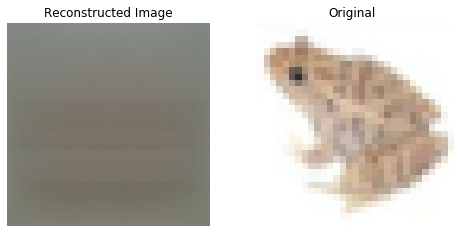

[Iteration 15800] -- MSE: 0.26661694049835205, KL: 0.0


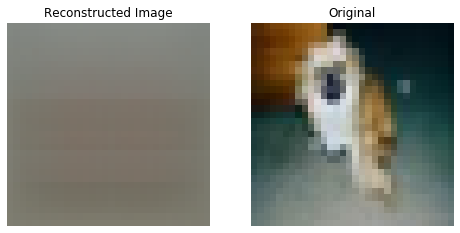

[Iteration 15900] -- MSE: 0.20793284475803375, KL: 0.0


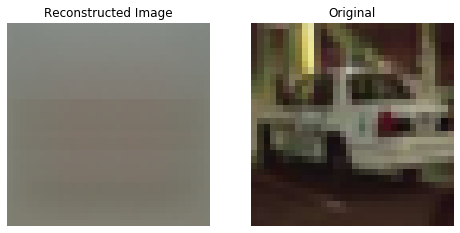

[Iteration 16000] -- MSE: 0.2716946005821228, KL: 0.0


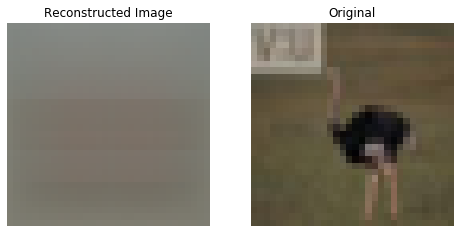

[Iteration 16100] -- MSE: 0.24324288964271545, KL: 0.0


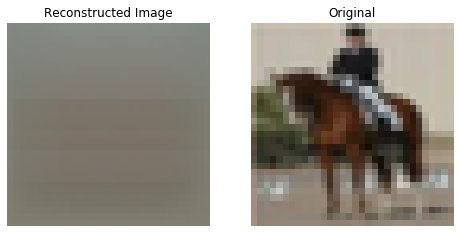

[Iteration 16200] -- MSE: 0.25302159786224365, KL: 0.0


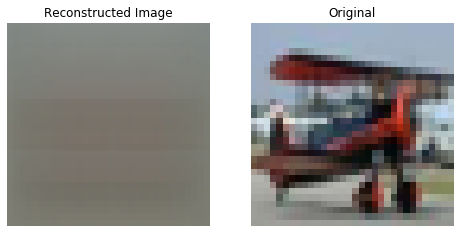

[Iteration 16300] -- MSE: 0.25293347239494324, KL: 0.0


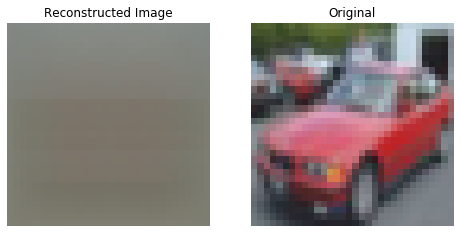

[Iteration 16400] -- MSE: 0.24643689393997192, KL: 0.0


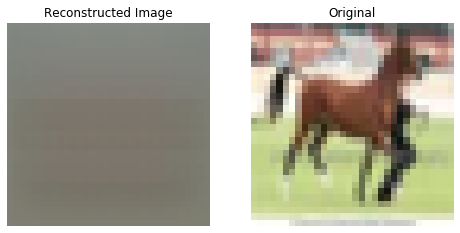

[Iteration 16500] -- MSE: 0.20837995409965515, KL: 0.0


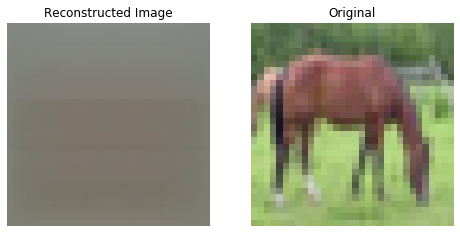

[Iteration 16600] -- MSE: 0.25428086519241333, KL: 0.0


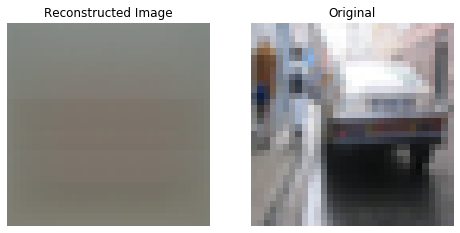

[Iteration 16700] -- MSE: 0.2538621723651886, KL: 0.0


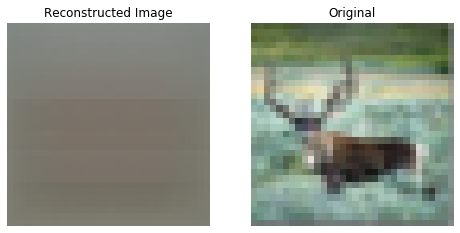

[Iteration 16800] -- MSE: 0.2506808042526245, KL: 0.0


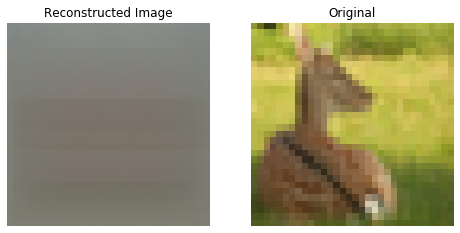

[Iteration 16900] -- MSE: 0.22928385436534882, KL: 0.0


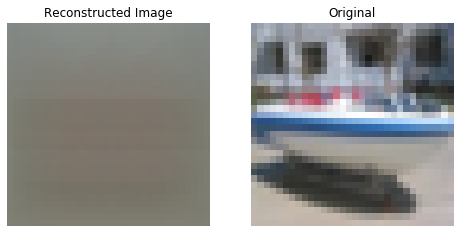

[Iteration 17000] -- MSE: 0.2727639973163605, KL: 0.0


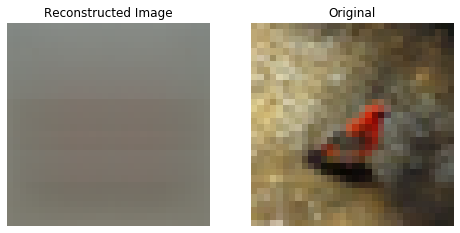

[Iteration 17100] -- MSE: 0.2523456811904907, KL: 0.0


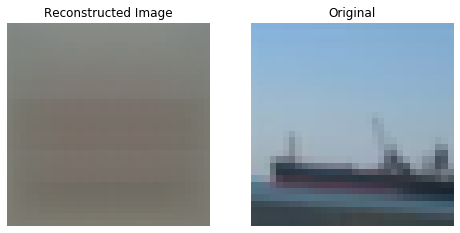

[Iteration 17200] -- MSE: 0.25478798151016235, KL: 0.0


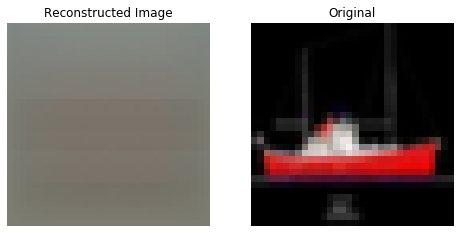

[Iteration 17300] -- MSE: 0.233221635222435, KL: 0.0


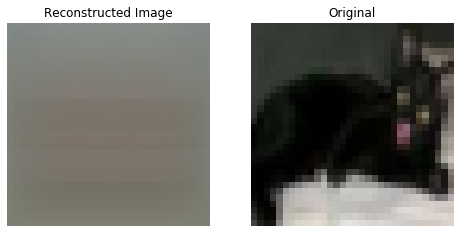

[Iteration 17400] -- MSE: 0.2215249240398407, KL: 0.0


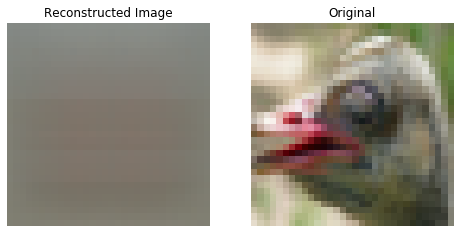

[Iteration 17500] -- MSE: 0.253346711397171, KL: 0.0


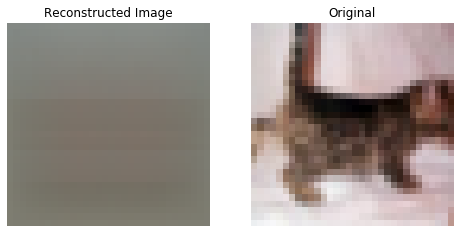

[Iteration 17600] -- MSE: 0.2495853155851364, KL: 0.0


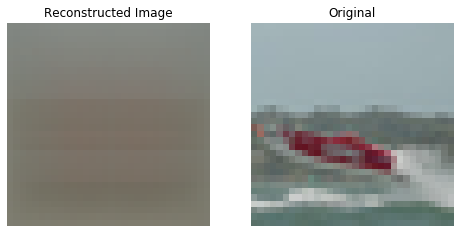

[Iteration 17700] -- MSE: 0.2572513818740845, KL: 0.0


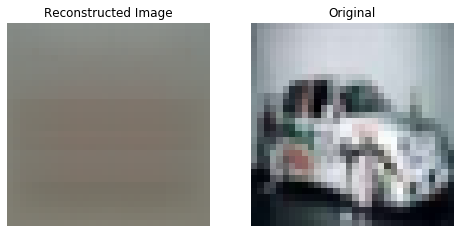

[Iteration 17800] -- MSE: 0.2395126223564148, KL: 0.0


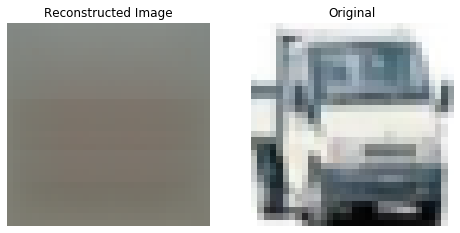

[Iteration 17900] -- MSE: 0.2262190580368042, KL: 0.0


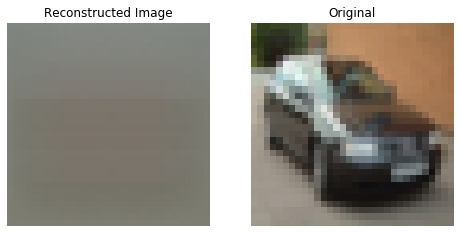

[Iteration 18000] -- MSE: 0.2422536015510559, KL: 0.0


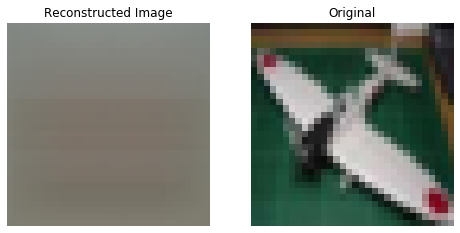

[Iteration 18100] -- MSE: 0.2497548907995224, KL: 0.0


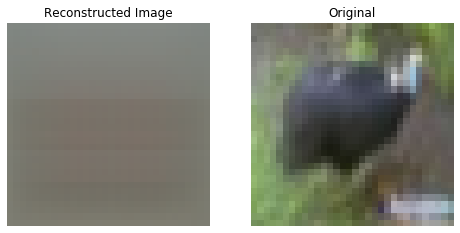

[Iteration 18200] -- MSE: 0.23296169936656952, KL: 0.0


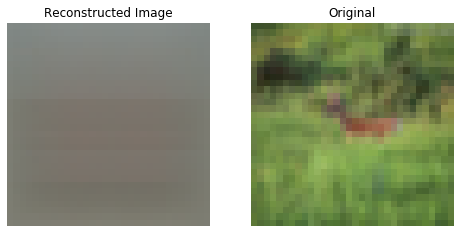

[Iteration 18300] -- MSE: 0.2747669816017151, KL: 0.0


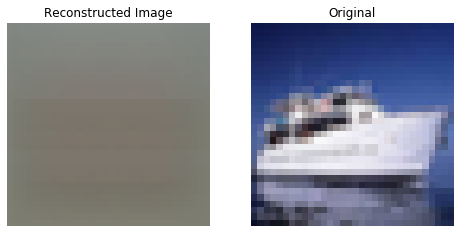

[Iteration 18400] -- MSE: 0.24562546610832214, KL: 0.0


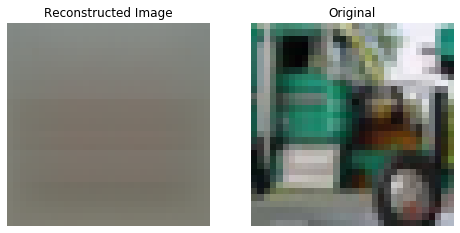

[Iteration 18500] -- MSE: 0.28960007429122925, KL: 0.0


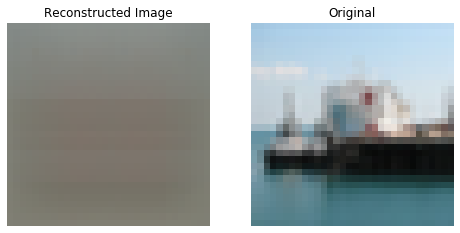

[Iteration 18600] -- MSE: 0.22532187402248383, KL: 0.0


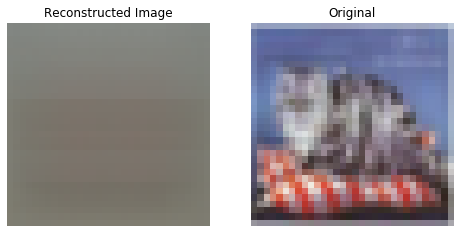

[Iteration 18700] -- MSE: 0.1955290138721466, KL: 0.0


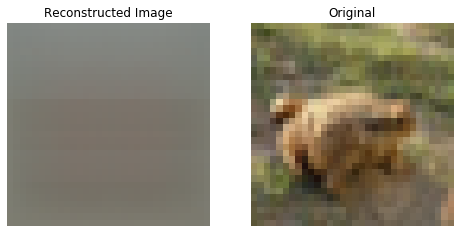

[Iteration 18800] -- MSE: 0.25185829401016235, KL: 0.0


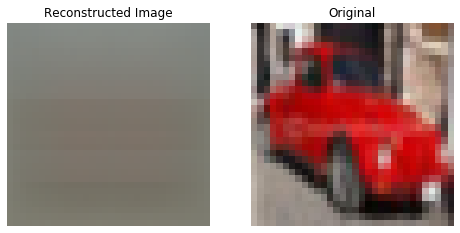

[Iteration 18900] -- MSE: 0.2065894603729248, KL: 0.0


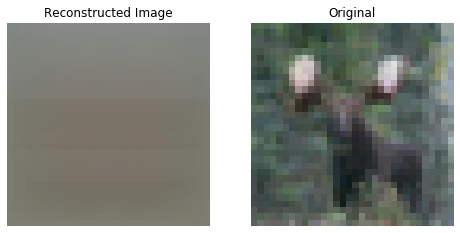

[Iteration 19000] -- MSE: 0.2676849067211151, KL: 0.0


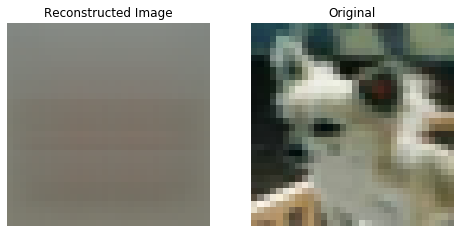

[Iteration 19100] -- MSE: 0.20365798473358154, KL: 0.0


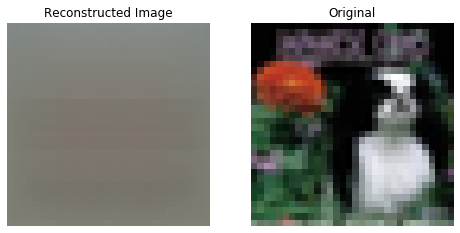

[Iteration 19200] -- MSE: 0.2700321674346924, KL: 0.0


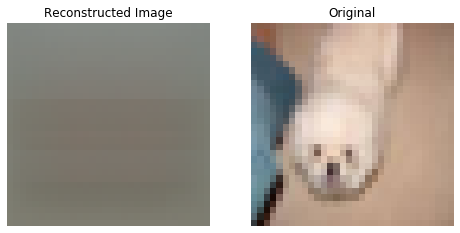

[Iteration 19300] -- MSE: 0.24737179279327393, KL: 0.0


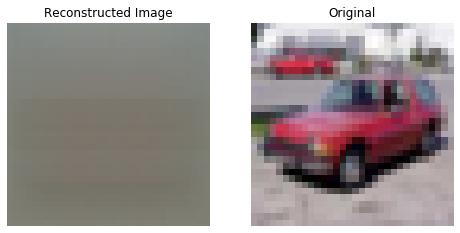

[Iteration 19400] -- MSE: 0.21274664998054504, KL: 0.0


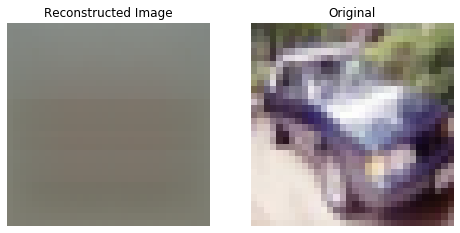

[Iteration 19500] -- MSE: 0.22370103001594543, KL: 0.0


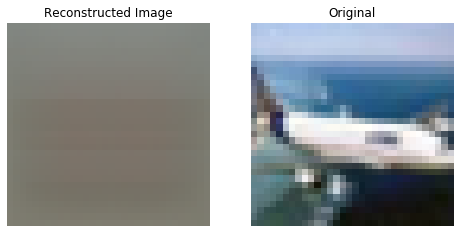

[Iteration 19600] -- MSE: 0.23243269324302673, KL: 0.0


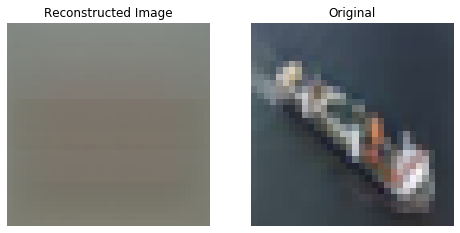

[Iteration 19700] -- MSE: 0.24418991804122925, KL: 0.0


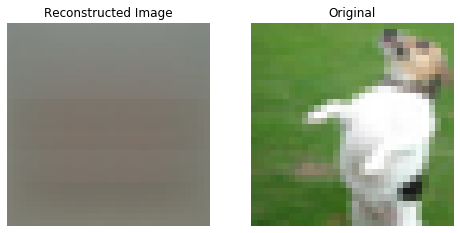

[Iteration 19800] -- MSE: 0.23546914756298065, KL: 0.0


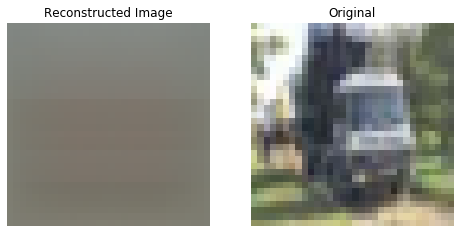

[Iteration 19900] -- MSE: 0.28152206540107727, KL: 0.0


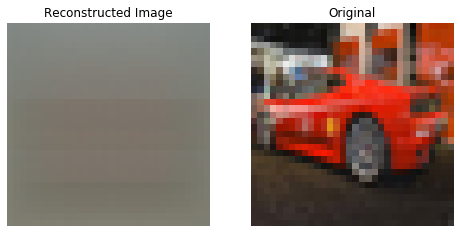

[Iteration 20000] -- MSE: 0.29896825551986694, KL: 0.0


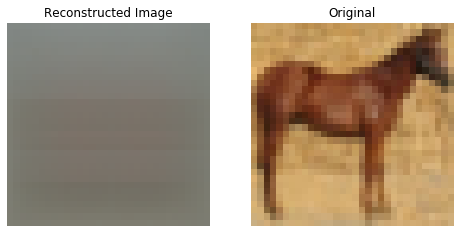

[Iteration 20100] -- MSE: 0.20712314546108246, KL: 0.0


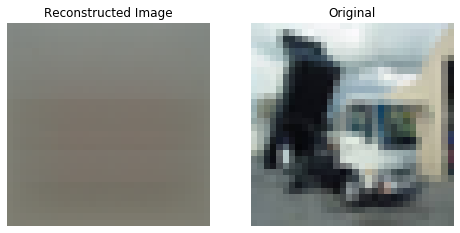

[Iteration 20200] -- MSE: 0.20419356226921082, KL: 0.0


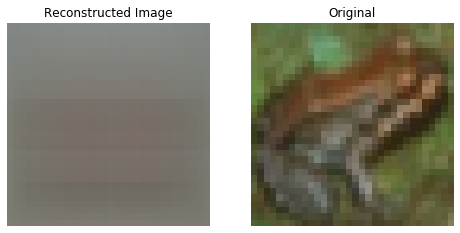

[Iteration 20300] -- MSE: 0.2490025907754898, KL: 0.0


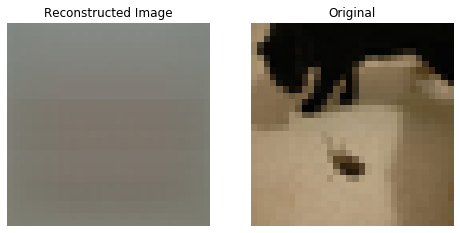

[Iteration 20400] -- MSE: 0.2403830587863922, KL: 0.0


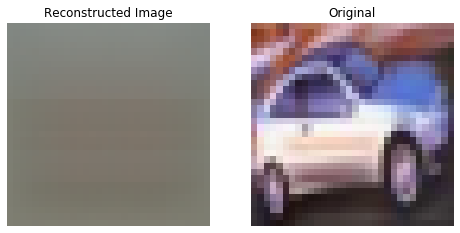

[Iteration 20500] -- MSE: 0.2437518835067749, KL: 0.0


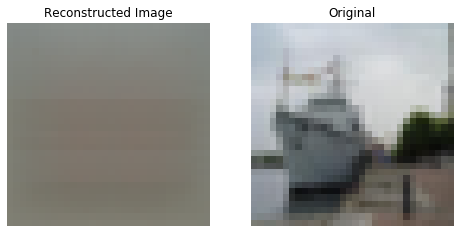

[Iteration 20600] -- MSE: 0.23694565892219543, KL: 0.0


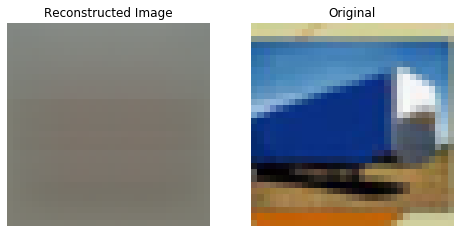

[Iteration 20700] -- MSE: 0.24235796928405762, KL: 0.0


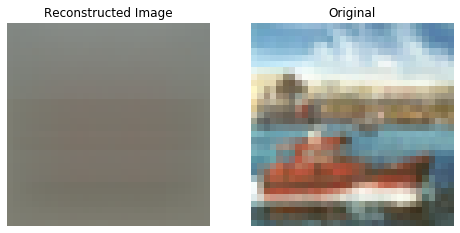

[Iteration 20800] -- MSE: 0.23097345232963562, KL: 0.0


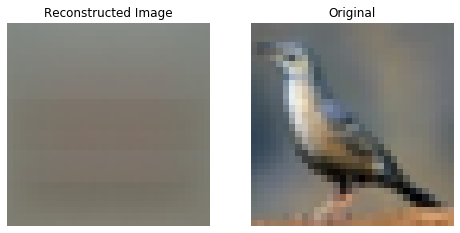

[Iteration 20900] -- MSE: 0.25620535016059875, KL: 0.0


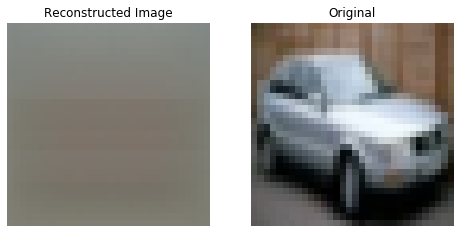

[Iteration 21000] -- MSE: 0.26389995217323303, KL: 0.0


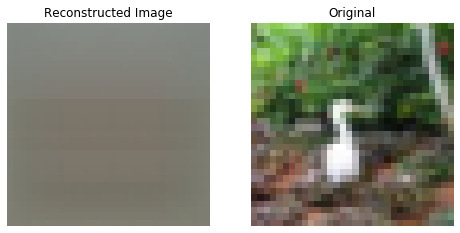

[Iteration 21100] -- MSE: 0.26819318532943726, KL: 0.0


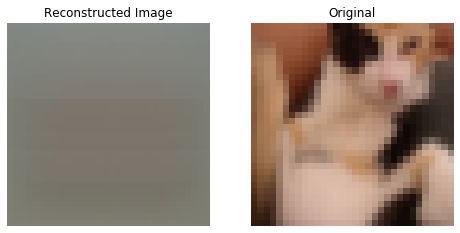

[Iteration 21200] -- MSE: 0.22377541661262512, KL: 0.0


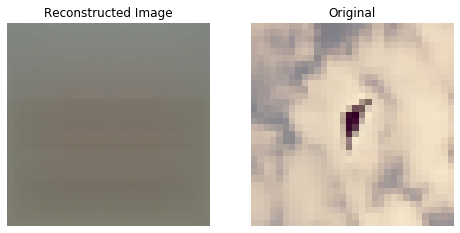

[Iteration 21300] -- MSE: 0.2126781940460205, KL: 0.0


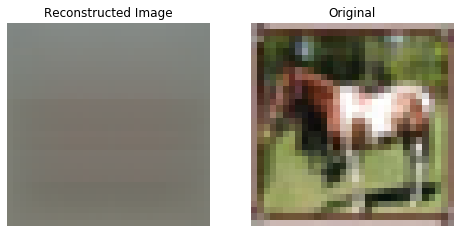

[Iteration 21400] -- MSE: 0.24965964257717133, KL: 0.0


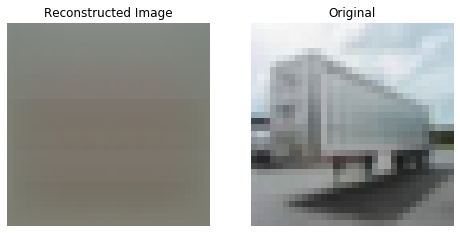

[Iteration 21500] -- MSE: 0.2272019386291504, KL: 0.0


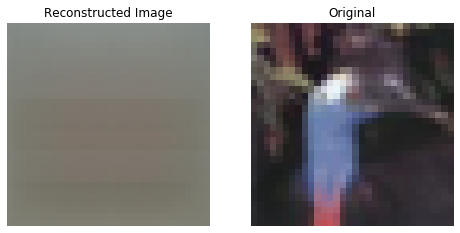

[Iteration 21600] -- MSE: 0.24931731820106506, KL: 0.0


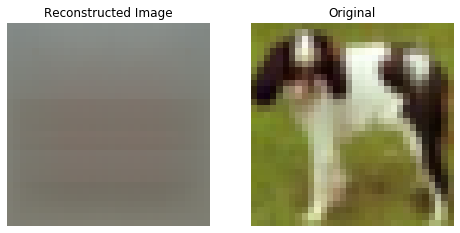

[Iteration 21700] -- MSE: 0.26449668407440186, KL: 0.0


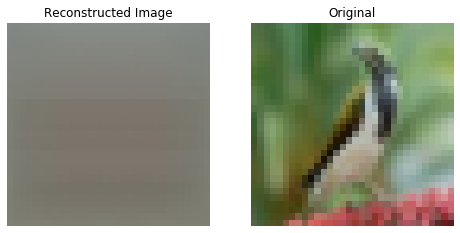

[Iteration 21800] -- MSE: 0.22899135947227478, KL: 0.0


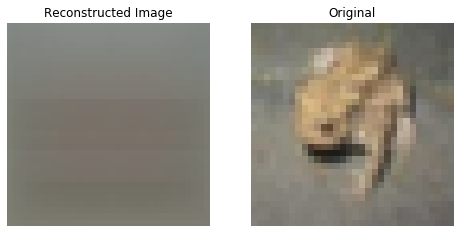

[Iteration 21900] -- MSE: 0.24609127640724182, KL: 0.0


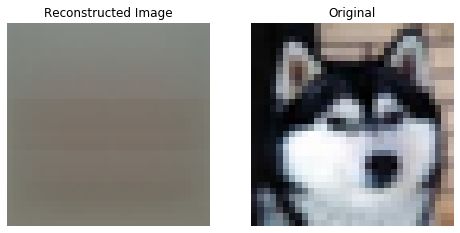

[Iteration 22000] -- MSE: 0.23131592571735382, KL: 0.0


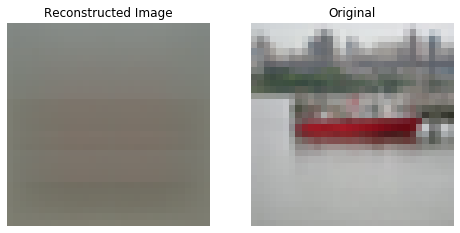

[Iteration 22100] -- MSE: 0.2415902018547058, KL: 0.0


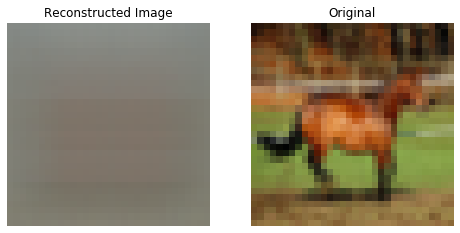

[Iteration 22200] -- MSE: 0.29184490442276, KL: 0.0


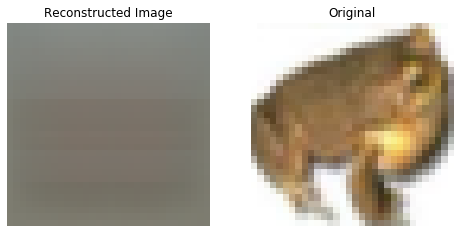

[Iteration 22300] -- MSE: 0.2360127568244934, KL: 0.0


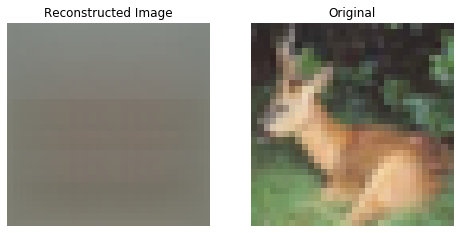

[Iteration 22400] -- MSE: 0.24588298797607422, KL: 0.0


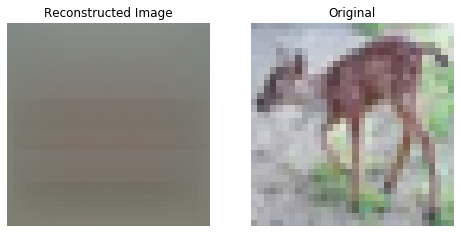

[Iteration 22500] -- MSE: 0.24657103419303894, KL: 0.0


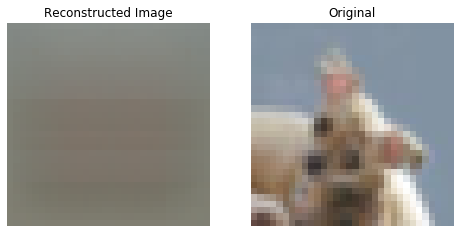

[Iteration 22600] -- MSE: 0.27221882343292236, KL: 0.0


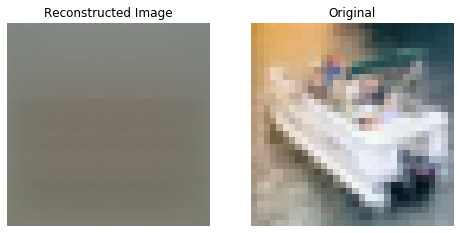

[Iteration 22700] -- MSE: 0.26342839002609253, KL: 0.0


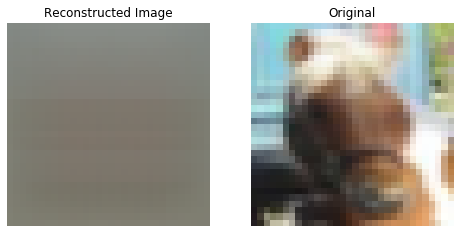

[Iteration 22800] -- MSE: 0.23676186800003052, KL: 0.0


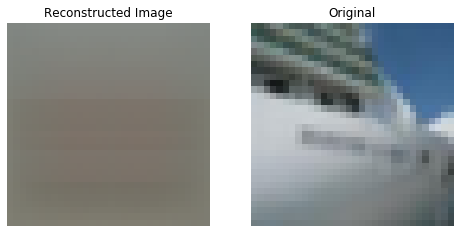

[Iteration 22900] -- MSE: 0.22900494933128357, KL: 0.0


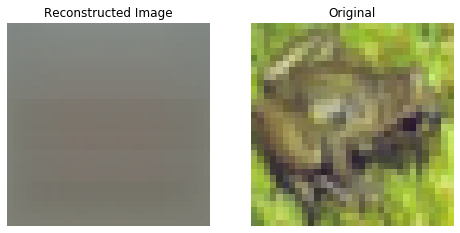

[Iteration 23000] -- MSE: 0.26427003741264343, KL: 0.0


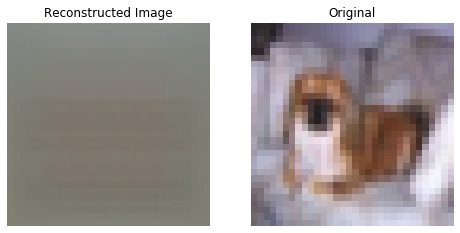

[Iteration 23100] -- MSE: 0.29830628633499146, KL: 0.0


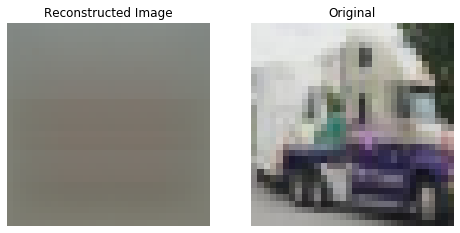

[Iteration 23200] -- MSE: 0.23338907957077026, KL: 0.0


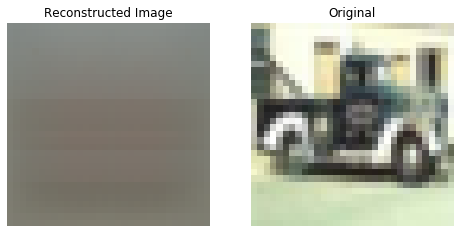

[Iteration 23300] -- MSE: 0.27670276165008545, KL: 0.0


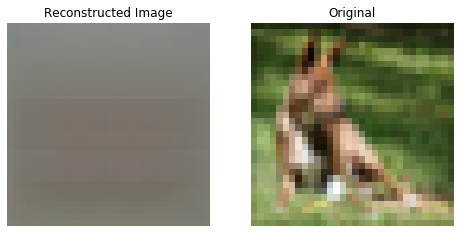

[Iteration 23400] -- MSE: 0.27515971660614014, KL: 0.0


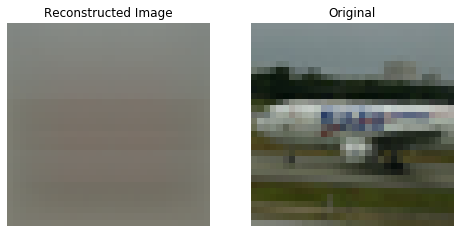

[Iteration 23500] -- MSE: 0.26351165771484375, KL: 0.0


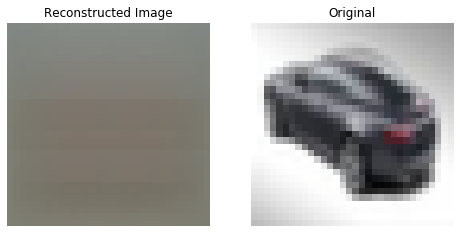

[Iteration 23600] -- MSE: 0.2616998851299286, KL: 0.0


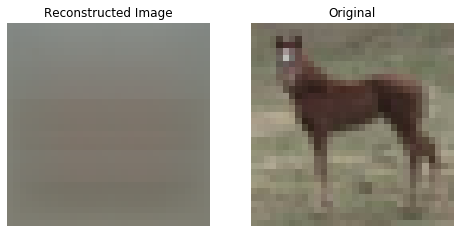

[Iteration 23700] -- MSE: 0.27323776483535767, KL: 0.0


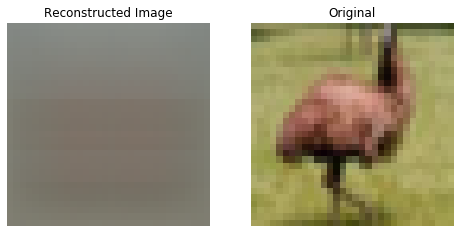

[Iteration 23800] -- MSE: 0.24917997419834137, KL: 0.0


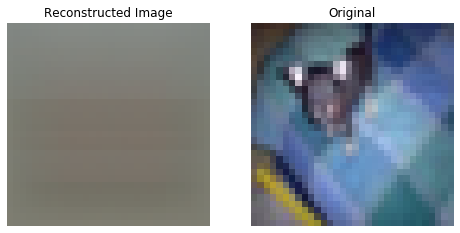

[Iteration 23900] -- MSE: 0.2781825661659241, KL: 0.0


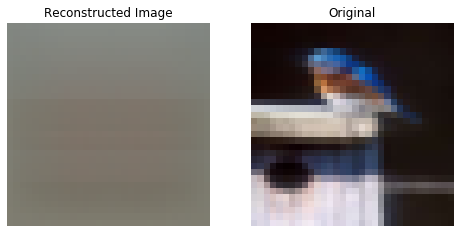

[Iteration 24000] -- MSE: 0.24484021961688995, KL: 0.0


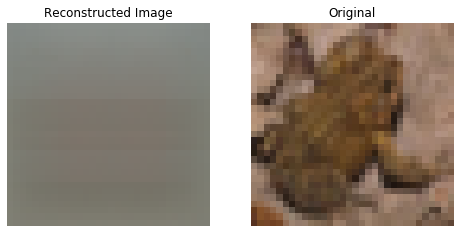

[Iteration 24100] -- MSE: 0.24942564964294434, KL: 0.0


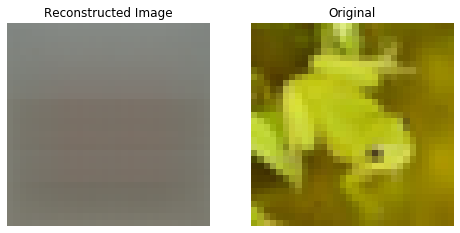

[Iteration 24200] -- MSE: 0.24175871908664703, KL: 0.0


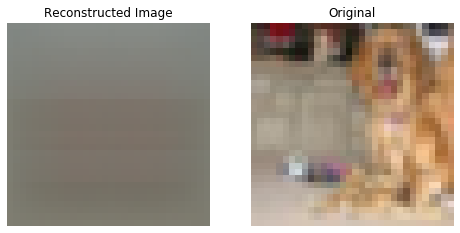

[Iteration 24300] -- MSE: 0.23223289847373962, KL: 0.0


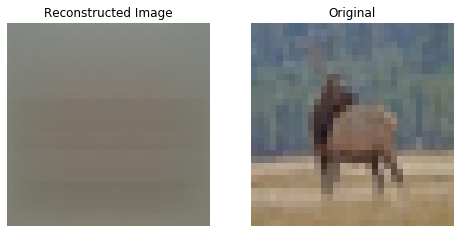

[Iteration 24400] -- MSE: 0.27768170833587646, KL: 0.0


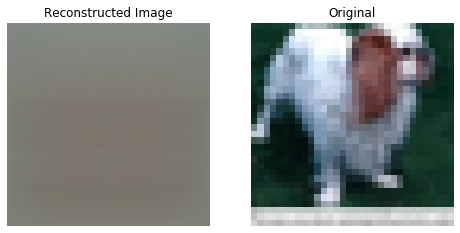

[Iteration 24500] -- MSE: 0.23736000061035156, KL: 0.0


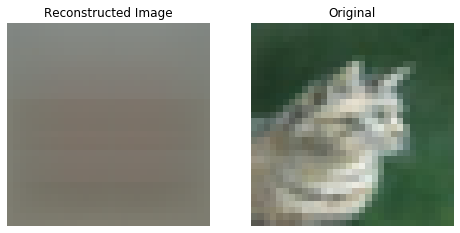

[Iteration 24600] -- MSE: 0.2286866009235382, KL: 0.0


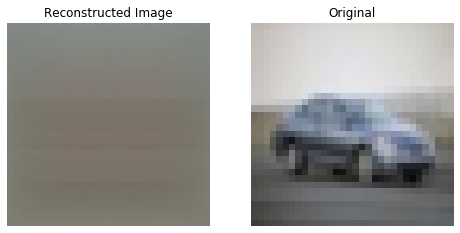

[Iteration 24700] -- MSE: 0.21702924370765686, KL: 0.0


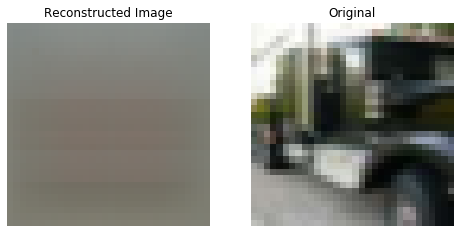

[Iteration 24800] -- MSE: 0.24768459796905518, KL: 0.0


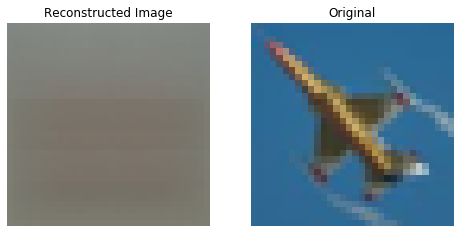

[Iteration 24900] -- MSE: 0.2515904903411865, KL: 0.0


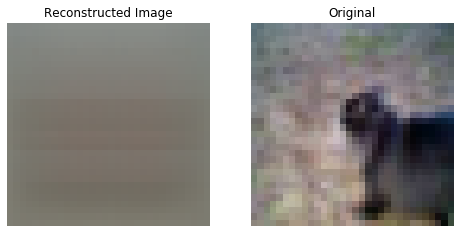

[Iteration 25000] -- MSE: 0.266080379486084, KL: 0.0


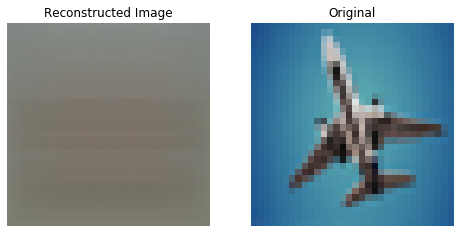

[Iteration 25100] -- MSE: 0.222724050283432, KL: 0.0


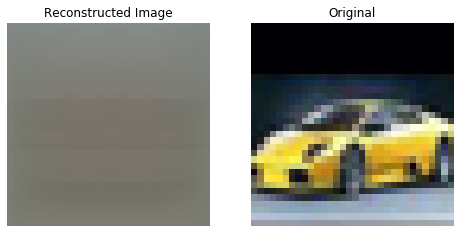

KeyboardInterrupt: 

In [8]:
for i, batch in enumerate(dataset):
    images = batch["image"]
    images = tf.cast(images, tf.float32) / 255.0 * 2.0 - 1.0
    optim.minimize(lambda: loss_function(images), model.trainable_variables)
    
    if i % 100 == 0:
        x, kl_loss = model(images)
        mse_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(images, x))
        print("[Iteration {}] -- MSE: {}, KL: {}".format(
            i, mse_loss.numpy(), kl_loss.numpy()))
        
        fig = plt.figure(figsize=(8, 8))
        axes = fig.add_subplot(1, 2, 1)
        axes.set_title("Reconstructed Image")
        axes.set_axis_off()
        plt.imshow(x[0] * 0.5 + 0.5)
        
        axes = fig.add_subplot(1, 2, 2)
        axes.set_title("Original")
        plt.imshow(images[0] * 0.5 + 0.5)
        axes.set_axis_off()
        plt.show()